### Term_Deposite_Prediction_Using_Supervised_Classification_Algorithms_With_Ensemble_Techniques 


---

**Data Description:** The data is collected from Machine Learning Repository(UCI). https://archive.ics.uci.edu/ml/datasets/Bank+Marketing#

The data is related with direct marketing campaigns of a ***Portuguese banking institution.*** The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed.

**Domain**: Banking

**Goal**: The classification goal is to predict if the client will subscribe (yes/no) a term deposit (variable y). 

**Data Set features Information:**

Features | Description 
:- | -: 
age| Age at the time of call
job| Type of job
marital| Marital status
education| Education background at the time of call
default| Has credit in default?
balance| Average yearly balance, in euros (numeric)
housing| Has housing loan?
loan| Has personal loan?
contact| Contact communication type
day| Last contact day of the month (1 -31)
month| Last contact month of year ('jan', 'feb', 'mar', ..., 'nov', 'dec')
duration| Last contact duration, in seconds (numeric). 
campaign| Number of contacts performed during this campaign and for this client (includes last contact)
pdays| Number of days that passed by after the client was last contacted from a previous campaign
previous| Number of contacts performed before this campaign and for this client
poutcome| Outcome of the previous marketing campaign
target| Has the client subscribed a term deposit? ('yes', 'no')



In [11]:
# Basic packages
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from scipy import stats; from scipy.stats import zscore, norm, randint
import matplotlib.style as style; style.use('fivethirtyeight')
import plotly.express as px
%matplotlib inline

# Impute and Encode
from sklearn.preprocessing import LabelEncoder
from impyute.imputation.cs import mice

# Modelling - LR, KNN, NB, Metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, recall_score, precision_score
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, BaggingClassifier, VotingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.dummy import DummyClassifier
from sklearn.metrics import make_scorer
from tqdm import tqdm_notebook

# Oversampling
from imblearn.over_sampling import SMOTE

# Suppress warnings
import warnings; warnings.filterwarnings('ignore')

# Visualize Tree
from sklearn.tree import export_graphviz
from IPython.display import Image
from os import system

# Display settings
pd.options.display.max_rows = 10000
pd.options.display.max_columns = 10000

random_state = 42
np.random.seed(random_state)
%matplotlib inline


In [12]:
bank = pd.read_csv('Bank_data_details.csv')
bank.head()


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,Target
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [13]:
bank.shape

(45211, 17)

<h2 align="center"> Exploratory Data Analysis (EDA) </h2>

In [14]:
bank.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  Target     45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


**Observation 1** - Dataset shape
Dataset has 45211 rows and 17 columns, with no missing values.

In [15]:
bank.describe().T


,count,mean,std,min,25%,50%,75%,max
age,45211.0,40.936210,10.618762,18.0,33.0,39.0,48.0,95.0
balance,45211.0,1362.272058,3044.765829,-8019.0,72.0,448.0,1428.0,102127.0
day,45211.0,15.806419,8.322476,1.0,8.0,16.0,21.0,31.0
duration,45211.0,258.163080,257.527812,0.0,103.0,180.0,319.0,4918.0
campaign,45211.0,2.763841,3.098021,1.0,1.0,2.0,3.0,63.0
pdays,45211.0,40.197828,100.128746,-1.0,-1.0,-1.0,-1.0,871.0
previous,45211.0,0.580323,2.303441,0.0,0.0,0.0,0.0,275.0


**Observation 2** -
Descriptive statistics for the numerical variables (age, balance, duration, campaign, pdays, previous)

Features | Description 
:- | -: 
age| Range of Q1 to Q3 is between 33 to 48. Since mean is slightly greater than median, we can say that age is right (positively) skewed.
balance| Range of Q1 to Q3 is between 72 to 1428. Since mean is greater than median, we can say that balance is skewed towards right (positively).
duration| Range of Q1 to Q3 is between 103 to 319. Since mean is greater than median, we can say that duration is right (positively) skewed.
campaign| Range of Q1 to Q3 is between 1 to 3. Since mean is greater than median, we can say that campaign is right (positively) skewed.
pdays| 75% of data values are around -1 which is a dummy value. It needs further check without considering the -1 value.
previous| 75% of data values are around 0 which is a dummy value, maybe cases where client wasn't contacted. It needs further checks.

In [16]:
columns = bank.loc[:, bank.dtypes == 'object'].columns.tolist()
for cols in columns:
    print(f'Unique values for {cols} is \n{bank[cols].unique()}\n')
    

Unique values for job is 
['management' 'technician' 'entrepreneur' 'blue-collar' 'unknown'
 'retired' 'admin.' 'services' 'self-employed' 'unemployed' 'housemaid'
 'student']

Unique values for marital is 
['married' 'single' 'divorced']

Unique values for education is 
['tertiary' 'secondary' 'unknown' 'primary']

Unique values for default is 
['no' 'yes']

Unique values for housing is 
['yes' 'no']

Unique values for loan is 
['no' 'yes']

Unique values for contact is 
['unknown' 'cellular' 'telephone']

Unique values for month is 
['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'jan' 'feb' 'mar' 'apr' 'sep']

Unique values for poutcome is 
['unknown' 'failure' 'other' 'success']

Unique values for Target is 
['no' 'yes']



**Observation 3** - Type of variables


1. Client info

Categorical| ..|Numerical|..
:- | -: |-:| -:
job| Nominal. Includes type of job. 'blue-collar' is the most frequently occurring in the data.|age|It seems it's discrete. Min age in the dataset being 18 and max being 95.
marital| Nominal. Most of the clients are married in the dataset we have.|balance| Continuous, ratio. Range of average yearly balance is very wide from -8019 euros to 102127 euros.
education| Ordinal. Most of the clients have secondary level education.|.|.
default| Binary. Most of clients don't have credit in default.|.|.
housing| Binary. Most of the clients have housing loan.|.|.
loan| Binary. Most of the clients don't have personal loan.|.|.

2. Last contact info

Categorical|..|Numerical|..
:- | -: |-:| -:
contact| Nominal. Includes communication type with the client, most frequently use communication mode is cellular.|duration| Continuous, interval. Includes last contact duration in seconds. Min value being 0 and max value being 4918. It would be important to check is higher duration of call leading to more subscription.
day| Ordinal. Includes last contact day of the month.|.|.
month| Ordinal. Includes last contact month of the year.|.|.

3. Previous campaign info

Categorical|..|Numerical|..
:- | -: |-:| -:
poutcome| Nominal. Includes outcome of the previous marketing campaign. Most occuring value being 'unknown'.|pdays| Continuous, interval. Min number of days that passed by after the client was last contacted from a previous 
campaign being -1 which may be dummy value for the cases where client wasn't contacted and max days being 63.
previous| Discrete, ratio. Min number of contacts performed before this campaign is 0 and max being 275.|campaign| Discrete, interval. Min number of contacts performed during this campaign being 1 and is also represents about 25% of the value and max being 63.


3. Target

Categorical|..
:- | -:
Target| Binary. Most occurring value being 'no' i.e. cases where the client didn't subscribe to the term deposit.



no     39922
yes     5289
Name: Target, dtype: int64


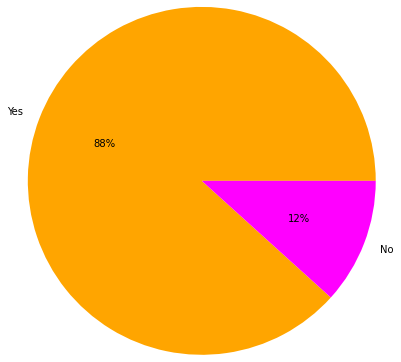

In [17]:
print(f"{bank['Target'].value_counts()}")

plt.pie(bank['Target'].value_counts(), labels=["Yes","No"], colors= ["orange","magenta"],autopct='%.0f%%',radius=2)
plt.show()


**Observation 4** - Distribution of target variable

Out of 45211 cases, only 5289 (=11.69%) are the cases where the client has subscribed to the term deposit. That means the dataset is quite imbalence.


In [18]:
# Replacing values in some of the categorical columns 
replace_values = {'education': {'unknown': -1, 'primary': 1, 'secondary': 2, 'tertiary': 3}, 'Target': {'no': 0, 'yes': 1},
                  'default': {'no': 0, 'yes': 1}, 'housing': {'no': 0, 'yes': 1}, 'loan': {'no': 0, 'yes': 1},
                  'month': {'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6, 
                            'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12}}

bank = bank.replace(replace_values)

In [19]:
# Convert columns to categorical types
columns.extend(['day'])
for cols in columns:
    bank[cols] = bank[cols].astype('category')
    

In [20]:
# Functions that will help us with EDA plot
class plots_for_EDA:
    
    def plot_for_outliers(self,df, col):
        f,(ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15, 7.2))

        # Boxplot to check outliers
        sns.boxplot(x = col, data = df, ax = ax1, orient = 'v', color = 'darkslategrey')

        # Distribution plot with outliers
        sns.distplot(df[col], ax = ax2, color = 'teal', fit = norm).set_title(f'Distribution of {col} with outliers')

        # Removing outliers, but in a new dataframe
        upperbound, lowerbound = np.percentile(df[col], [1, 99])
        y = pd.DataFrame(np.clip(df[col], upperbound, lowerbound))

        # Distribution plot without outliers
        sns.distplot(y[col], ax = ax3, color = 'tab:orange', fit = norm).set_title(f'Distribution of {col} without outliers')

        kwargs = {'fontsize':14, 'color':'black'}
        ax1.set_title(col + ' Boxplot Analysis', **kwargs)
        ax1.set_xlabel('Box', **kwargs)
        ax1.set_ylabel(col + ' Values', **kwargs)

        return plt.show()

    def target_plot(self,df, col, target = 'Target'):
        fig = plt.figure(figsize = (15, 7.2))

        # Distribution for 'Target' -- didn't subscribed, considering outliers   
        ax = fig.add_subplot(121)
        sns.distplot(df[(df[target] == 0)][col], color = 'c', 
                     ax = ax).set_title(f'{col.capitalize()} for Term Desposit - Didn\'t subscribed')

        # Distribution for 'Target' -- Subscribed, considering outliers
        ax= fig.add_subplot(122)
        sns.distplot(df[(df[target] == 1)][col], color = 'b', 
                 ax = ax).set_title(f'{col.capitalize()} for Term Desposit - Subscribed')
        return plt.show()

    def feature_vs_count_plot(self,df, col1, col2):
        #plotting 2features one by one horizontly
        fig = plt.figure(figsize = (15, 7.2))
        ax = fig.add_subplot(121)
        
        #feture1
        sns.countplot(x = col1, data = df, palette = ['tab:blue', 'tab:cyan'], ax = ax, orient = 'v',
                      hue = 'Target').set_title(col1.capitalize() +' count plot by Target', fontsize = 13)
        
        plt.legend(labels = ['Didn\'t Subcribed', 'Subcribed'])
        plt.xticks(rotation = 90)
        
        #feature2
        ax = fig.add_subplot(122)
        sns.countplot(x = col2, data = df, palette = ['tab:blue', 'tab:cyan'], ax = ax, orient = 'v', 
                      hue = 'Target').set_title(col2.capitalize() +' coount plot by Target', fontsize = 13)
        plt.legend(labels = ['Didn\'t Subcribed', 'Subcribed'])
        plt.xticks(rotation = 90)
        return plt.show()

## Univariate Visualization
Looking at one feature at a time to understand how are the values distributed, checking outliers, checking relation of the column with Target column.

In [21]:
plot_EDA= plots_for_EDA()


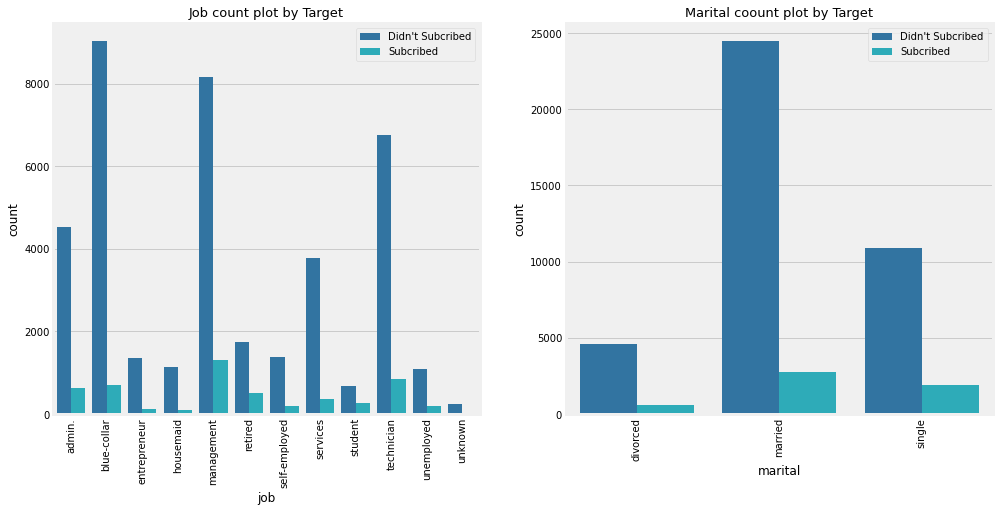

In [22]:
plot_EDA.feature_vs_count_plot(bank, 'job', 'marital')


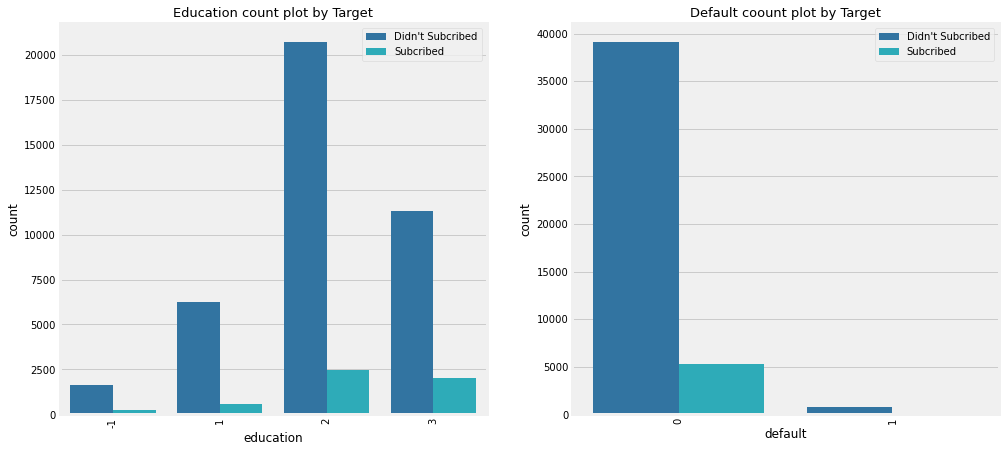

In [23]:
plot_EDA.feature_vs_count_plot(bank,'education', 'default')


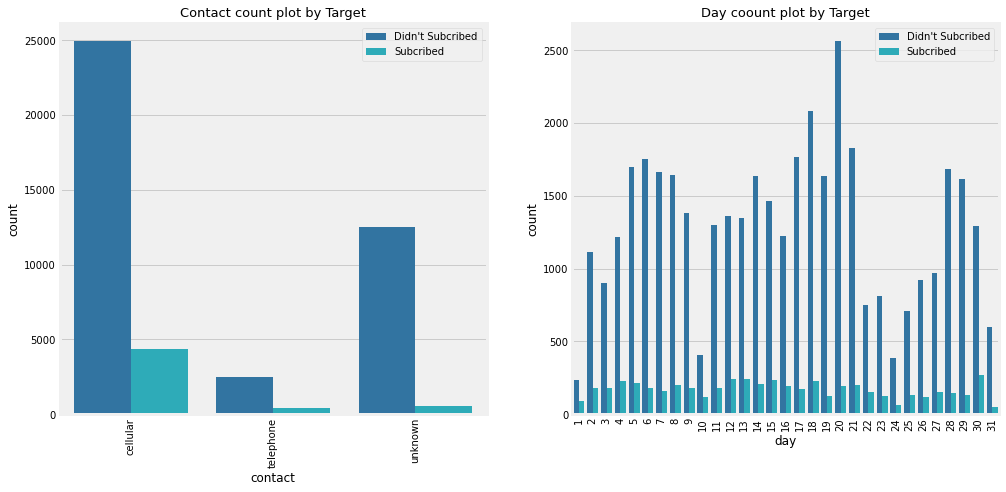

In [24]:
plot_EDA.feature_vs_count_plot(bank,'contact', 'day')


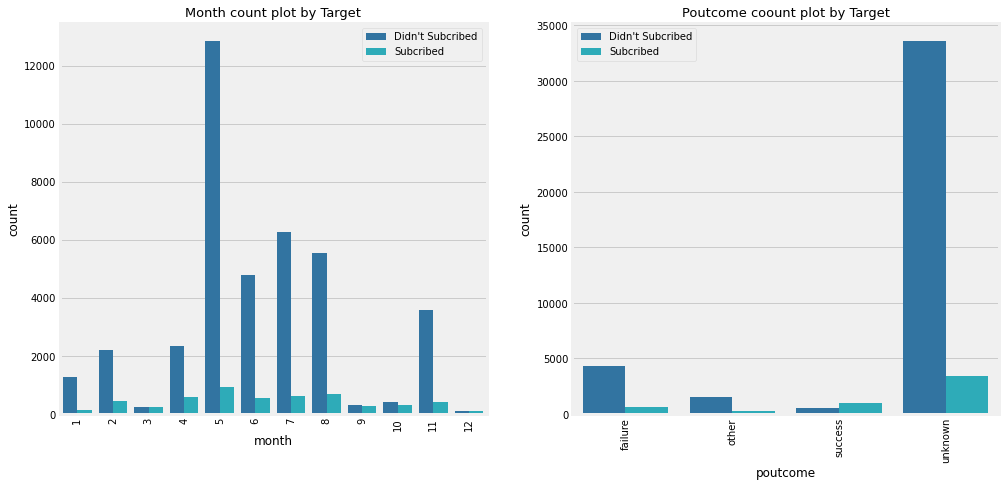

In [25]:
plot_EDA.feature_vs_count_plot(bank,'month', 'poutcome')


**Observation 5** - Comments from categorical columns
- Management job clients have a subscription rate of ~25 percent followed by technician job clients.
- Married and single clients are more likely to subscribe then divorced clients
- Clients with education of secondary followed by tertiary are more likely to subscribe to term deposits
- Most of the clients don't have credit in default and their subscription rate is higher then people with default
- Cellular communication type have higher subscription rate
- Most of the subscription were made in May and August

In [26]:
#Checking outlier and distribution for numerical columns and also ploting it's relation with target variable
def Outlier_distribution(col):
    Q3 = bank[col].quantile(0.75)
    Q1 = bank[col].quantile(0.25)
    IQR = Q3 - Q1

    print(f"{col} column {'--'*55}")

    display(bank.loc[(bank[col] < (Q1 - 1.5 * IQR)) | (bank[col] > (Q3 + 1.5 * IQR))].head())

    plot_EDA.plot_for_outliers(bank, col)

    # Distribution of 'age' by 'Target'
    plot_EDA.target_plot(bank, col)
    

age column --------------------------------------------------------------------------------------------------------------


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,Target
29158,83,retired,married,1,0,425,0,0,telephone,2,2,912,1,-1,0,unknown,0
29261,75,retired,divorced,1,0,46,0,0,cellular,2,2,294,1,-1,0,unknown,0
29263,75,retired,married,1,0,3324,0,0,cellular,2,2,149,1,-1,0,unknown,0
29322,83,retired,married,3,0,6236,0,0,cellular,2,2,283,2,-1,0,unknown,0
29865,75,retired,divorced,1,0,3881,1,0,cellular,4,2,136,3,-1,0,unknown,1


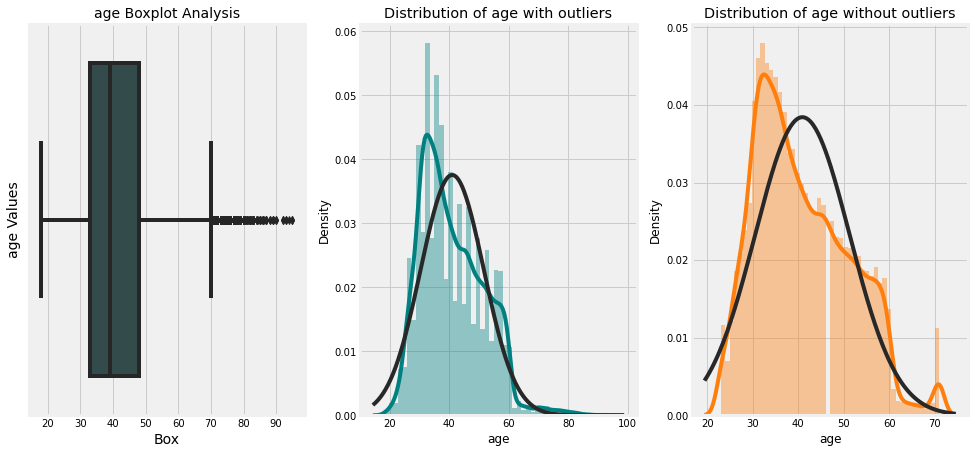

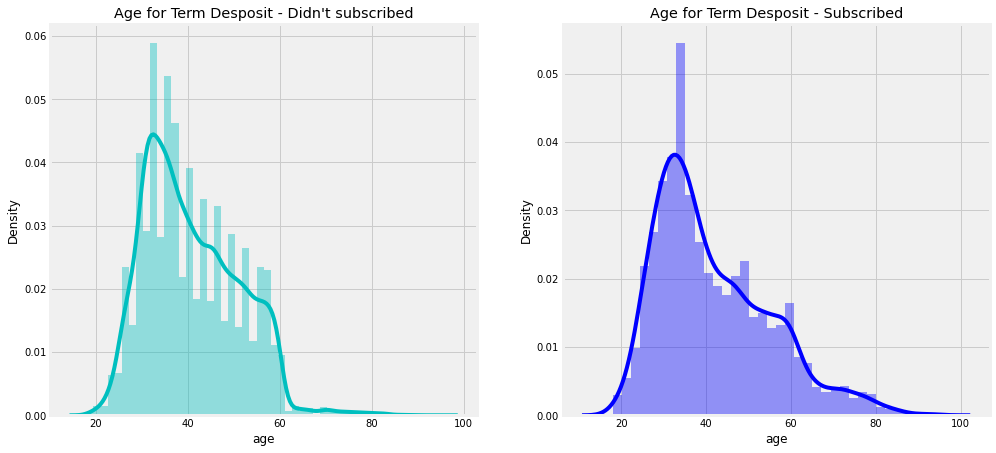

In [27]:
Outlier_distribution("age")


balance column --------------------------------------------------------------------------------------------------------------


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,Target
34,51,management,married,3,0,10635,1,0,unknown,5,5,336,1,-1,0,unknown,0
65,51,management,married,3,0,6530,1,0,unknown,5,5,91,1,-1,0,unknown,0
69,35,blue-collar,single,2,0,12223,1,1,unknown,5,5,177,1,-1,0,unknown,0
70,57,blue-collar,married,2,0,5935,1,1,unknown,5,5,258,1,-1,0,unknown,0
186,40,services,divorced,-1,0,4384,1,0,unknown,5,5,315,1,-1,0,unknown,0


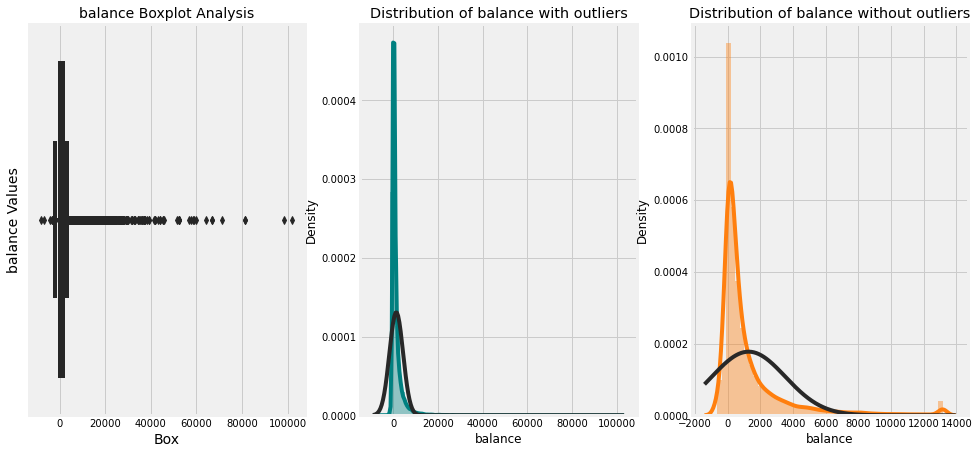

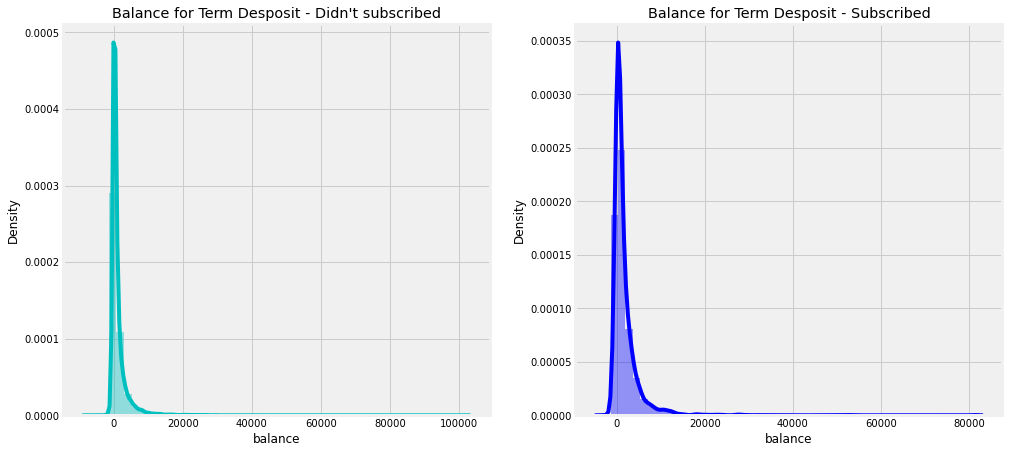

In [28]:
Outlier_distribution('balance')

duration column --------------------------------------------------------------------------------------------------------------


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,Target
37,53,technician,married,2,0,-3,0,0,unknown,5,5,1666,1,-1,0,unknown,0
43,54,retired,married,2,0,529,1,0,unknown,5,5,1492,1,-1,0,unknown,0
53,42,admin.,single,2,0,-76,1,0,unknown,5,5,787,1,-1,0,unknown,0
59,46,services,married,1,0,179,1,0,unknown,5,5,1778,1,-1,0,unknown,0
61,53,technician,divorced,2,0,989,1,0,unknown,5,5,812,1,-1,0,unknown,0


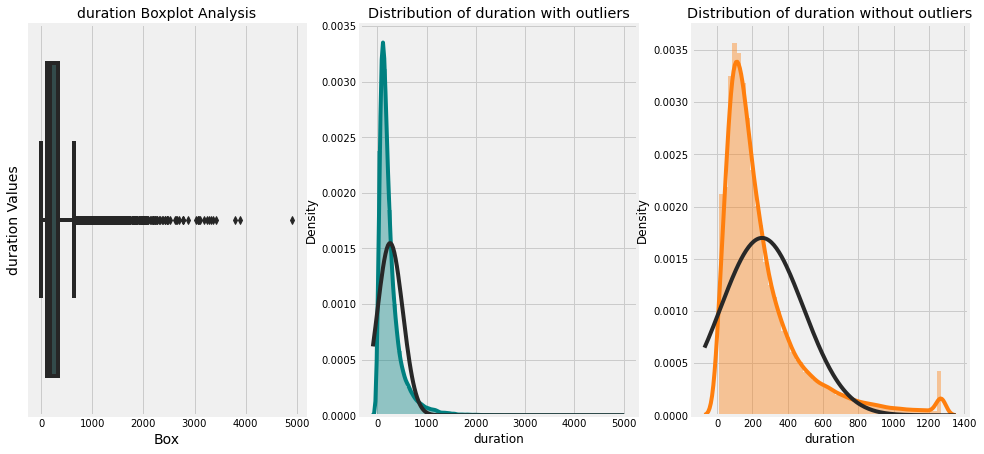

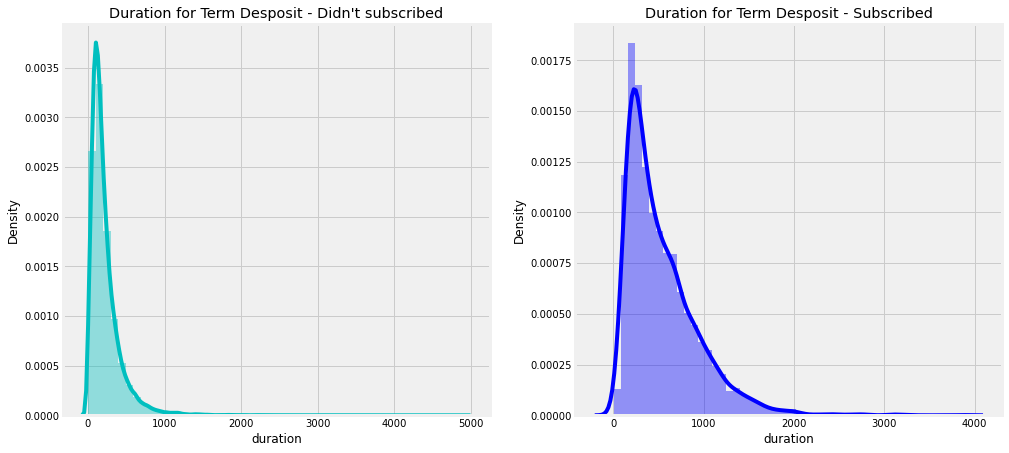

In [29]:
Outlier_distribution("duration")

campaign column --------------------------------------------------------------------------------------------------------------


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,Target
758,59,services,married,2,0,307,1,1,unknown,6,5,250,7,-1,0,unknown,0
780,30,admin.,married,2,0,4,0,0,unknown,7,5,172,8,-1,0,unknown,0
906,27,services,single,2,0,0,1,0,unknown,7,5,388,7,-1,0,unknown,0
1103,52,technician,married,-1,0,133,1,0,unknown,7,5,253,8,-1,0,unknown,0
1105,43,admin.,married,3,0,1924,1,0,unknown,7,5,244,7,-1,0,unknown,0


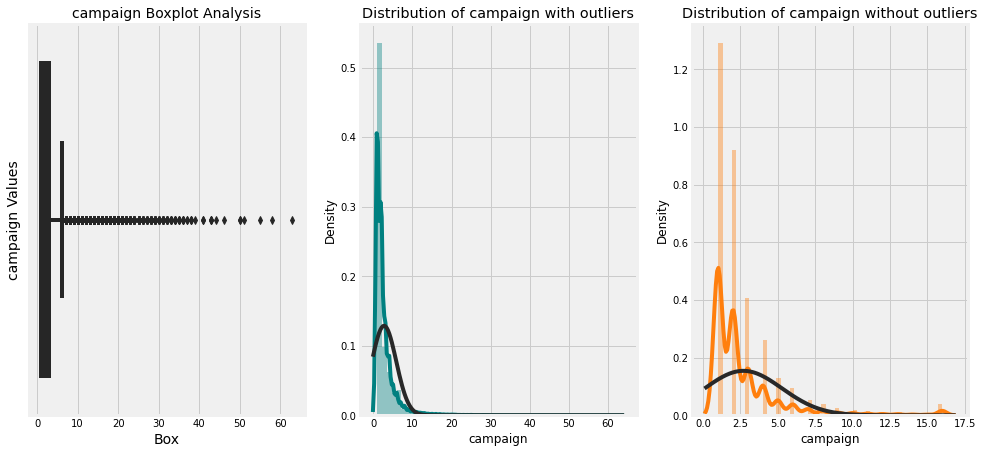

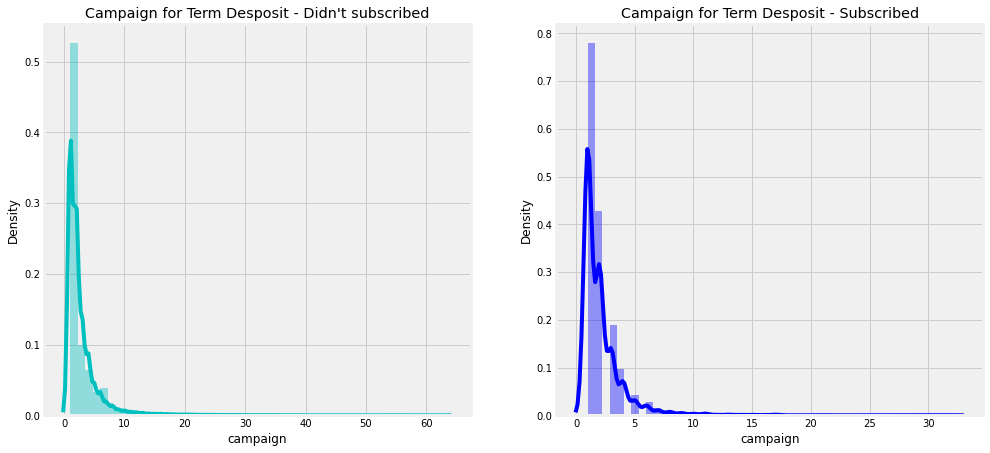

In [30]:
Outlier_distribution('campaign')

pdays column --------------------------------------------------------------------------------------------------------------


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,Target
24060,33,admin.,married,3,0,882,0,0,telephone,21,10,39,1,151,3,failure,0
24062,42,admin.,single,2,0,-247,1,1,telephone,21,10,519,1,166,1,other,1
24064,33,services,married,2,0,3444,1,0,telephone,21,10,144,1,91,4,failure,1
24072,36,management,married,3,0,2415,1,0,telephone,22,10,73,1,86,4,other,0
24077,36,management,married,3,0,0,1,0,telephone,23,10,140,1,143,3,failure,1


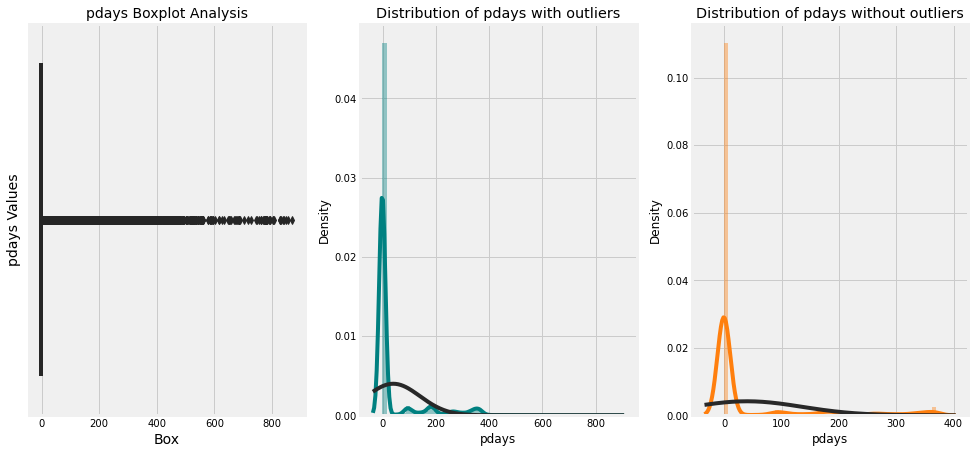

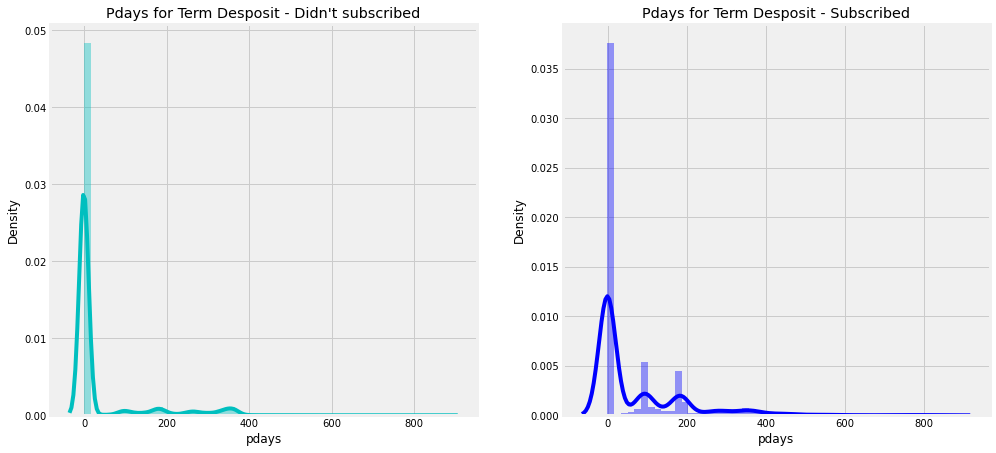

In [31]:
Outlier_distribution('pdays')

previous column --------------------------------------------------------------------------------------------------------------


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,Target
24060,33,admin.,married,3,0,882,0,0,telephone,21,10,39,1,151,3,failure,0
24062,42,admin.,single,2,0,-247,1,1,telephone,21,10,519,1,166,1,other,1
24064,33,services,married,2,0,3444,1,0,telephone,21,10,144,1,91,4,failure,1
24072,36,management,married,3,0,2415,1,0,telephone,22,10,73,1,86,4,other,0
24077,36,management,married,3,0,0,1,0,telephone,23,10,140,1,143,3,failure,1


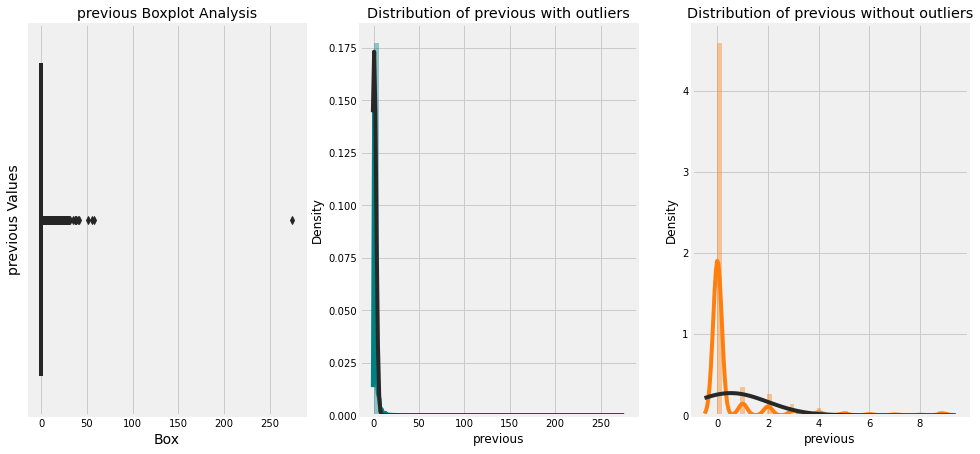

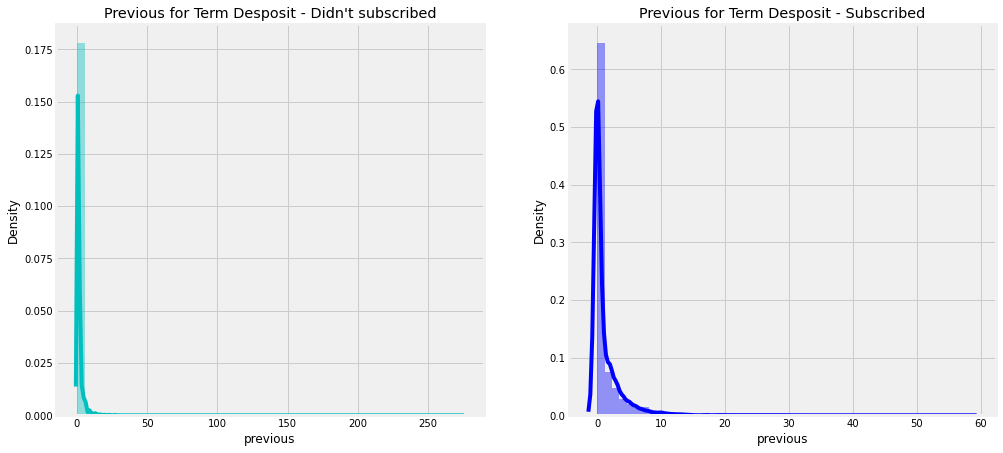

In [32]:
Outlier_distribution("previous")

**Observation 6** - Comments from numerical columns

- Used quantile method to check outliers in numerical column. It appears that there are outliers in each of the numerical columns.
- It appears that removing outliers below 25% percentile and above 75% percentile will bring the age and pdays columns to almost normal distribution.

In [33]:
# Printing categorical and numerical columns list
print('Categorical Columns: \n{}'.format(list(bank.select_dtypes('category').columns)))
print('\nNumerical Columns: \n{}'.format(list(bank.select_dtypes(exclude = 'category').columns)))


Categorical Columns: 
['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'day', 'month', 'poutcome', 'Target']

Numerical Columns: 
['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']


In [34]:
# Removing outliers with upper and lower percentile values being 99 and 1, respectively
bank_nulls = bank.copy(deep = True)
columns = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']

for col in columns:
    upper_lim = np.percentile(bank_nulls[col].values, 99)
    lower_lim = np.percentile(bank_nulls[col].values, 1)
    bank_nulls.loc[(bank_nulls[col] > upper_lim), col] = np.nan
    bank_nulls.loc[(bank_nulls[col] < lower_lim), col] = np.nan

print('Column for which outliers where removed with upper and lower percentile values: \n', columns)


Column for which outliers where removed with upper and lower percentile values: 
 ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']


In [35]:
bank_nulls.isna().sum()


age          738
job            0
marital        0
education      0
default        0
balance      903
housing        0
loan           0
contact        0
day            0
month          0
duration     870
campaign     451
pdays        385
previous     453
poutcome       0
Target         0
dtype: int64

In [36]:
bank_nulls.head()


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,Target
0,58.0,management,married,3,0,2143.0,1,0,unknown,5,5,261.0,1.0,-1.0,0.0,unknown,0
1,44.0,technician,single,2,0,29.0,1,0,unknown,5,5,151.0,1.0,-1.0,0.0,unknown,0
2,33.0,entrepreneur,married,2,0,2.0,1,1,unknown,5,5,76.0,1.0,-1.0,0.0,unknown,0
3,47.0,blue-collar,married,-1,0,1506.0,1,0,unknown,5,5,92.0,1.0,-1.0,0.0,unknown,0
4,33.0,unknown,single,-1,0,1.0,0,0,unknown,5,5,198.0,1.0,-1.0,0.0,unknown,0


In [37]:
# Encoding the dummy values 
cols_to_transform = ['job', 'marital', 'contact', 'poutcome']
bank_nulls = pd.get_dummies(bank_nulls, columns = cols_to_transform) #, drop_first = True)

print('Got dummies for \n', cols_to_transform)


Got dummies for 
 ['job', 'marital', 'contact', 'poutcome']


In [38]:
bank_nulls.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 35 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   age                44473 non-null  float64 
 1   education          45211 non-null  category
 2   default            45211 non-null  category
 3   balance            44308 non-null  float64 
 4   housing            45211 non-null  category
 5   loan               45211 non-null  category
 6   day                45211 non-null  category
 7   month              45211 non-null  category
 8   duration           44341 non-null  float64 
 9   campaign           44760 non-null  float64 
 10  pdays              44826 non-null  float64 
 11  previous           44758 non-null  float64 
 12  Target             45211 non-null  category
 13  job_admin.         45211 non-null  uint8   
 14  job_blue-collar    45211 non-null  uint8   
 15  job_entrepreneur   45211 non-null  uint8   
 16  job_

In [39]:
# Converting type of categorical columns to integer/float for getting it ready for processing
columns = ['education', 'default', 'housing', 'loan', 'day', 'month', 'Target']
for col in columns:
    bank_nulls[col] = bank_nulls[col].astype('float')
    

In [40]:
bank_nulls.isna().sum()


age                  738
education              0
default                0
balance              903
housing                0
loan                   0
day                    0
month                  0
duration             870
campaign             451
pdays                385
previous             453
Target                 0
job_admin.             0
job_blue-collar        0
job_entrepreneur       0
job_housemaid          0
job_management         0
job_retired            0
job_self-employed      0
job_services           0
job_student            0
job_technician         0
job_unemployed         0
job_unknown            0
marital_divorced       0
marital_married        0
marital_single         0
contact_cellular       0
contact_telephone      0
contact_unknown        0
poutcome_failure       0
poutcome_other         0
poutcome_success       0
poutcome_unknown       0
dtype: int64

### Multivariate Imputation By Chained Equations (MICE) algorithm for missing values 

In [41]:
# start the MICE training
bank_imputed = mice(bank_nulls.values)
bank_imputed = pd.DataFrame(bank_imputed, columns = bank_nulls.columns)



In [42]:
bank_imputed.head()


,age,education,default,balance,housing,loan,day,month,duration,campaign,pdays,previous,Target,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,contact_cellular,contact_telephone,contact_unknown,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,58.0,3.0,0.0,2143.0,1.0,0.0,5.0,5.0,261.0,1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,44.0,2.0,0.0,29.0,1.0,0.0,5.0,5.0,151.0,1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,33.0,2.0,0.0,2.0,1.0,1.0,5.0,5.0,76.0,1.0,-1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,47.0,-1.0,0.0,1506.0,1.0,0.0,5.0,5.0,92.0,1.0,-1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,33.0,-1.0,0.0,1.0,0.0,0.0,5.0,5.0,198.0,1.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [43]:
bank_imputed.describe(include = 'all').T


,count,mean,std,min,25%,50%,75%,max
age,45211.0,40.836870,10.073690,23.000000,33.0,39.0,48.0,71.743841
education,45211.0,2.019442,0.902795,-1.000000,2.0,2.0,3.0,3.000000
default,45211.0,0.018027,0.133049,0.000000,0.0,0.0,0.0,1.000000
balance,45211.0,1174.932363,1898.534988,-812.502754,81.0,467.0,1402.0,13164.000000
housing,45211.0,0.555838,0.496878,0.000000,0.0,1.0,1.0,1.000000
loan,45211.0,0.160226,0.366820,0.000000,0.0,0.0,0.0,1.000000
day,45211.0,15.806419,8.322476,1.000000,8.0,16.0,21.0,31.000000
month,45211.0,6.144655,2.408034,1.000000,5.0,6.0,8.0,12.000000
duration,45211.0,247.428930,211.290370,11.000000,106.0,183.0,316.0,1269.000000
campaign,45211.0,2.562222,2.214906,1.000000,1.0,2.0,3.0,16.000000


In [44]:
bank_imputed.isna().sum()


age                  0
education            0
default              0
balance              0
housing              0
loan                 0
day                  0
month                0
duration             0
campaign             0
pdays                0
previous             0
Target               0
job_admin.           0
job_blue-collar      0
job_entrepreneur     0
job_housemaid        0
job_management       0
job_retired          0
job_self-employed    0
job_services         0
job_student          0
job_technician       0
job_unemployed       0
job_unknown          0
marital_divorced     0
marital_married      0
marital_single       0
contact_cellular     0
contact_telephone    0
contact_unknown      0
poutcome_failure     0
poutcome_other       0
poutcome_success     0
poutcome_unknown     0
dtype: int64

## Multivariate analysis
Checking relationship between two or more variables. Includes correlation and scatterplot matrix, checking relation between two variables and Target.


In [45]:
# sns.pairplot(bank_imputed[['age', 'education', 'default', 'balance', 'housing', 'loan', 'day', 'month', 
#                            'duration', 'campaign', 'pdays', 'previous', 'Target']], hue = 'Target')


Text(0.5, 1.0, 'Correlation Matrix of Data')

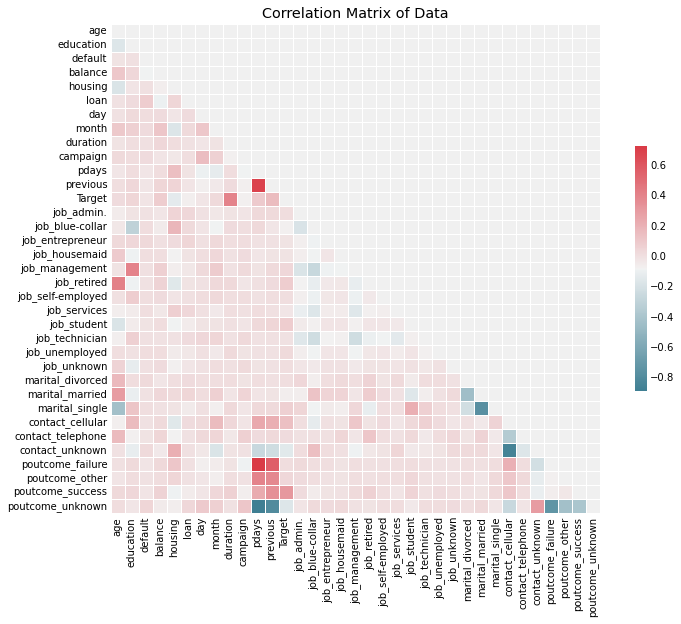

In [46]:
# Correlation matrix for all variables
corr = bank_imputed.corr()

mask = np.zeros_like(corr, dtype = np.bool)

mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize = (11, 9))

cmap = sns.diverging_palette(220, 10, as_cmap = True)

sns.heatmap(corr, mask = mask, cmap = cmap, square = True, linewidths = .5, cbar_kws = {"shrink": .5})#, annot = True)
ax.set_title('Correlation Matrix of Data')

In [47]:
# Filter for correlation value greater than 0.8
sort = corr.abs().unstack()
sort = sort.sort_values(kind = "quicksort", ascending = False)
sort[(sort > 0.8) & (sort < 1)]


pdays             poutcome_unknown    0.891235
poutcome_unknown  pdays               0.891235
contact_cellular  contact_unknown     0.862398
contact_unknown   contact_cellular    0.862398
previous          poutcome_unknown    0.806952
poutcome_unknown  previous            0.806952
dtype: float64

**Observation 7** - Correlation Matrix

poutcome_unknown and pdays; contact_unknown and contact_cellular; poutcome_unknown and previous; marital_married and marital_single; poutcome_unknown and poutcome_failure; pdays and poutcome_failure; previous and pdays; poutcome_failure and previous columns are correlated with each other.


In [48]:
col_to_drop = ["pdays","contact_cellular","poutcome_unknown"]


In [49]:
bank_imputed.drop(col_to_drop,inplace=True, axis = 1)


In [50]:
# Absolute correlation of independent variables with 'Target' feature

absCorrwithDep = []
allVars = bank_imputed.drop('Target', axis = 1).columns

for var in allVars:
    absCorrwithDep.append(abs(bank_imputed['Target'].corr(bank_imputed[var])))

display(pd.DataFrame([allVars, absCorrwithDep], index = ['Variable', 'Correlation']).T.\
        sort_values('Correlation', ascending = False))


,Variable,Correlation
8,duration,0.398107
30,poutcome_success,0.306788
10,previous,0.153341
27,contact_unknown,0.150935
4,housing,0.139173
16,job_retired,0.079245
3,balance,0.076923
19,job_student,0.076897
9,campaign,0.075451
12,job_blue-collar,0.072083


**Observation 8:** 

duration, poutcome_success, poutcome_unknown and previous are few columns which have a relatively strong correlation with Target column.



In [51]:
# Creating Groups for age and checking relation with balance and target campaign and target features
bank_imputed.loc[(bank_imputed['age'] < 30), 'age_group'] = 20
bank_imputed.loc[(bank_imputed['age'] >= 30) & (bank_imputed['age'] < 40), 'age_group'] = 30
bank_imputed.loc[(bank_imputed['age'] >= 40) & (bank_imputed['age'] < 50), 'age_group'] = 40
bank_imputed.loc[(bank_imputed['age'] >= 50) & (bank_imputed['age'] < 60), 'age_group'] = 50
bank_imputed.loc[(bank_imputed['age'] >= 60), 'age_group'] = 60


Text(0.5, 1.0, 'Relationship between balance and age group by Target')

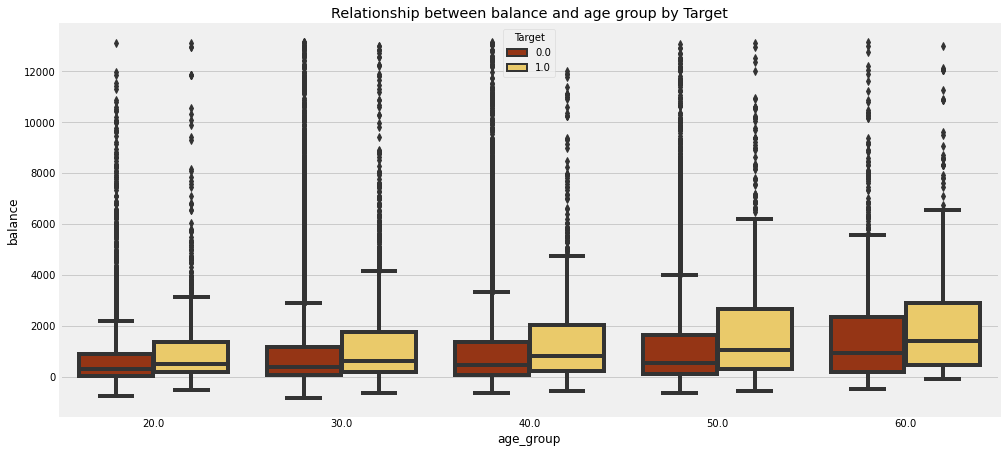

In [52]:
# Checking relationship between balance and age group by Target
fig = plt.figure(figsize = (15, 7.2))
ax = sns.boxplot(x = 'age_group', y = 'balance', hue = 'Target', palette = 'afmhot', data = bank_imputed)
ax.set_title('Relationship between balance and age group by Target')


Text(0.5, 1.0, 'Relationship between campaign and age group by Target')

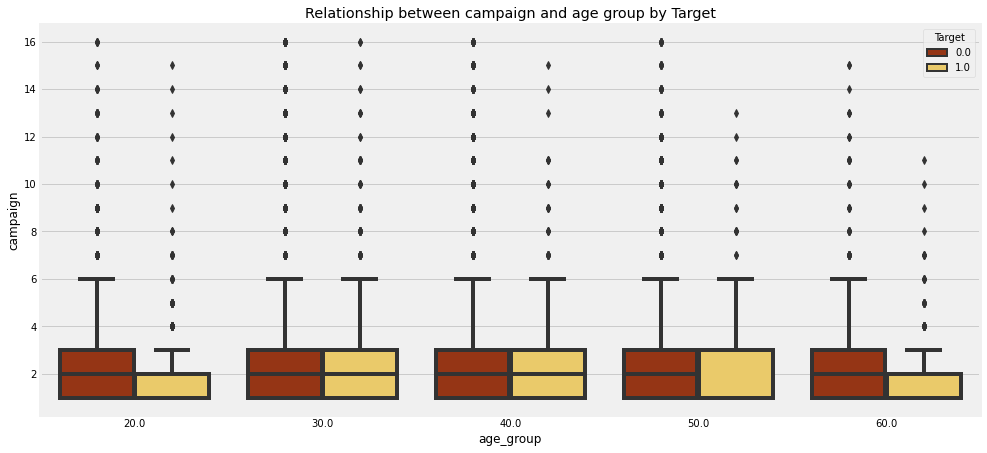

In [53]:
# Check relationship between campaign and age group by Target
fig = plt.figure(figsize = (15, 7.2))
ax = sns.boxplot(x = 'age_group', y = 'campaign', hue = 'Target', palette = 'afmhot', data = bank_imputed)
ax.set_title('Relationship between campaign and age group by Target')


 **Observation 10** - Comments

- Created age_group and checked it's relation with balance and target and it appears that higher the balance range more are the chances that the client would subscribe to the term deposit irrespective of age group. It also appears that clients within age group 50 have the highest range of balance.

- Then checked relation between campaign, age group and target and it appears that campaigns for client with age group 20 and 60 are less.

In [54]:
# Final data after EDA
bank_imputed.head()


,age,education,default,balance,housing,loan,day,month,duration,campaign,previous,Target,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,contact_telephone,contact_unknown,poutcome_failure,poutcome_other,poutcome_success,age_group
0,58.0,3.0,0.0,2143.0,1.0,0.0,5.0,5.0,261.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,50.0
1,44.0,2.0,0.0,29.0,1.0,0.0,5.0,5.0,151.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,40.0
2,33.0,2.0,0.0,2.0,1.0,1.0,5.0,5.0,76.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,30.0
3,47.0,-1.0,0.0,1506.0,1.0,0.0,5.0,5.0,92.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,40.0
4,33.0,-1.0,0.0,1.0,0.0,0.0,5.0,5.0,198.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,30.0


---

# Machine Learning Models

In [55]:
# Applying RobustScaler for dealing with outliers

from sklearn.preprocessing import RobustScaler
X = bank_imputed.drop(['Target'], axis = 1)
y = bank_imputed['Target']

features = X.columns
scaler = RobustScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns = features)

# Scaling the independent variables
Xs = X.apply(zscore)



In [56]:
# Creating a base line using dummy classifier
# DummyClassifier makes predictions that ignore the input features.
# This classifier serves as a simple baseline to compare against other more complex classifiers.

X = bank_imputed.drop(['Target'], axis = 1)
y = bank_imputed['Target']

#Splitting the data into training and test set in the ratio of 70:30 respectively

X_train, X_test, y_train, y_test = train_test_split(Xs, y, test_size = 0.3, random_state = random_state)

dummy = DummyClassifier(strategy = 'most_frequent', random_state = random_state)
dummy.fit(X_train, y_train)
y_pred = dummy.predict(X_test)

accuracy_ = accuracy_score(y_test, y_pred)
pre_s = precision_score(y_test, y_pred, average = 'binary', pos_label = 1)
f1_s = f1_score(y_test, y_pred, average = 'binary', pos_label = 1)

pre_m = precision_score(y_test, y_pred, average = 'macro')
f1_m = f1_score(y_test, y_pred, average = 'macro')

print(classification_report(y_pred,y_test))


              precision    recall  f1-score   support

         0.0       1.00      0.88      0.94     13564
         1.0       0.00      0.00      0.00         0

    accuracy                           0.88     13564
   macro avg       0.50      0.44      0.47     13564
weighted avg       1.00      0.88      0.94     13564



In [57]:
df = pd.DataFrame([accuracy_.round(3), pre_s.round(3), pre_m.round(3), 
                   f1_s.round(3), f1_m.round(3)], columns = ['Baseline Model']).T
df.columns = ['Accuracy', 'Precision_Subscribe(1)', 'Precision_Overall(Macro Avg)',
             'f1_Subscribe', 'f1_Overall(Macro Avg)']
df


,Accuracy,Precision_Subscribe(1),Precision_Overall(Macro Avg),f1_Subscribe,f1_Overall(Macro Avg)
Baseline Model,0.882,0.0,0.441,0.0,0.469


- Precision and recall for baseline model is quite bad for class 1 as it is predicting all sample data as class 0

---

In [58]:
# Baseline model on Oversampled data

X = bank_imputed.drop(['Target'], axis = 1)
y = bank_imputed['Target']

X_train, X_test, y_train, y_test = train_test_split(Xs, y, test_size = 0.3, random_state = random_state)


#Oversampling
sm = SMOTE(random_state = random_state, sampling_strategy = 'minority')
X_train_oversampled, y_train_oversampled = sm.fit_resample(X_train, y_train) #Oversampled data



dummy = DummyClassifier(strategy = 'uniform', random_state = random_state)
dummy.fit(X_train_oversampled, y_train_oversampled)
y_pred = dummy.predict(X_test)

accuracy_ = accuracy_score(y_test, y_pred)
pre_s = precision_score(y_test, y_pred, average = 'binary', pos_label = 1)
re_s = recall_score(y_test, y_pred, average = 'binary', pos_label = 1)
f1_s = f1_score(y_test, y_pred, average = 'binary', pos_label = 1)

pre_m = precision_score(y_test, y_pred, average = 'macro')
re_m = recall_score(y_test, y_pred, average = 'macro')
f1_m = f1_score(y_test, y_pred, average = 'macro')

print(classification_report(y_pred,y_test))


              precision    recall  f1-score   support

         0.0       0.50      0.89      0.64      6778
         1.0       0.52      0.12      0.20      6786

    accuracy                           0.50     13564
   macro avg       0.51      0.50      0.42     13564
weighted avg       0.51      0.50      0.42     13564



In [59]:
df_oversampled = pd.DataFrame([accuracy_.round(3), pre_s.round(3), pre_m.round(3), re_s.round(3), 
                   re_m.round(3), f1_s.round(3), f1_m.round(3)], columns = ['Baseline Model, Oversampled']).T
df_oversampled.columns = ['Accuracy', 'Precision_Subscribe(1)', 'Precision_Overall(Macro Avg)',
               'Recall_Subscribe', 'Recall_Overall(Macro Avg)', 'f1_Subscribe', 'f1_Overall(Macro Avg)']
df_oversampled

,Accuracy,Precision_Subscribe(1),Precision_Overall(Macro Avg),Recall_Subscribe,Recall_Overall(Macro Avg),f1_Subscribe,f1_Overall(Macro Avg)
"Baseline Model, Oversampled",0.503,0.121,0.503,0.515,0.508,0.196,0.418


In [60]:
# Helper function for making prediction and evaluating scores
def train_and_predict(n_splits, base_model, X, y, name, subscribe = 1, oversampling = False):
    features = X.columns
    X = np.array(X)
    y = np.array(y)
    
    folds = list(StratifiedKFold(n_splits = n_splits, shuffle = True, random_state = random_state).split(X, y))
    
    train_pred = np.zeros((X.shape[0], len(base_model)))
    
    accuracy = []

    precision_subscribe = []
    recall_subscribe = []
    f1_subscribe = []
    
    precision_macro = []
    recall_macro = []
    f1_macro = []
    
    for i, clf in enumerate(base_model):
        for j, (train, test) in enumerate(folds):
            
            # Creating train and test sets
            X_train = X[train]
            y_train = y[train]
            X_test = X[test]
            y_test = y[test]
            
            # Oversampling to balane the dataset
            if oversampling:
                sm = SMOTE(random_state = random_state, sampling_strategy = 'minority')
                X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
           
            # fit the model
                clf.fit(X_train_oversampled, y_train_oversampled)

            # Get predictions
                y_true, y_pred = y_test, clf.predict(X_test)

            # Evaluate train and test scores
                train_ = clf.score(X_train_oversampled, y_train_oversampled)
                test_ = clf.score(X_test, y_test)
            
            else:
            
            # fit the model
                clf.fit(X_train, y_train)

            # Get predictions
                y_true, y_pred = y_test, clf.predict(X_test)

            # Evaluate train and test scores
                train_ = clf.score(X_train, y_train)
                test_ = clf.score(X_test, y_test)
                      
            # Other scores
            accuracy_ = accuracy_score(y_true, y_pred).round(3)
            
            precision_b = precision_score(y_true, y_pred, average = 'binary', pos_label = subscribe).round(3)
            recall_b = recall_score(y_true, y_pred, average = 'binary', pos_label = subscribe).round(3)
            f1_b = f1_score(y_true, y_pred, average = 'binary', pos_label = subscribe).round(3)
            
            precision_m = precision_score(y_true, y_pred, average = 'macro').round(3)
            recall_m = recall_score(y_true, y_pred, average = 'macro').round(3)
            f1_m = f1_score(y_true, y_pred, average = 'macro').round(3)
            
            print(f'Model- {name.capitalize()} and CV- {j}')
            print('-'*20)
            print('Training Score: {0:.3f}'.format(train_))
            print('Test Score: {0:.3f}'.format(test_))
            
            print('Accuracy Score: {0:.3f}'.format(accuracy_))
            
            print('Precision Score - Subscribe: {0:.3f}'.format(precision_b))
            print('Recall Score - Subscribe: {0:.3f}'.format(recall_b))
            print('f1 Score - Subscribe: {0:.3f}'.format(f1_b))
            
            print('Precision Score - Macro: {0:.2f}'.format(precision_m))
            print('Recall Score - Macro: {0:.3f}'.format(recall_m))
            print('f1 Score - Macro: {0:.3f}'.format(f1_m))
            print('\n')
            
            ## Appending scores   
            accuracy.append(accuracy_)
            precision_subscribe.append(precision_b)
            recall_subscribe.append(recall_b)
            f1_subscribe.append(f1_b)
            precision_macro.append(precision_m)
            recall_macro.append(recall_m)
            f1_macro.append(f1_m)
                       
            # Creating a dataframe of scores
            df = pd.DataFrame([np.mean(accuracy).round(2), np.mean(precision_subscribe).round(3), 
                               np.mean(precision_macro).round(3), np.mean(recall_subscribe).round(3), 
                               np.mean(recall_macro).round(3), np.mean(f1_subscribe).round(3), 
                               np.mean(f1_macro).round(3)], columns = [name]).T
            df.columns = ['Accuracy', 'Precision_Subscribe(1)', 'Precision_Overall(Macro Avg)',
                          'Recall_Subscribe', 'Recall_Overall(Macro Avg)', 'f1_Subscribe', 'f1_Overall(Macro Avg)']
            
    return df


# Logistic Regression

In [61]:
parameters ={"C":[0.01,0.1,1],'penalty':['l2',"l1"], 'solver':['newton-cg', 'lbfgs','liblinear']}# l1 lasso l2 ridge
lr=LogisticRegression()

gsvc= GridSearchCV(lr,parameters, scoring = 'accuracy',cv=10)
logreg_cv = gsvc.fit(X_train, y_train)

In [62]:
print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)

tuned hpyerparameters :(best parameters)  {'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'}


In [63]:
# LR model 
LR = LogisticRegression(C= 0.01, penalty= 'l1', solver= 'liblinear')
base_model = [LR]
n_splits = 5
df1 = train_and_predict(n_splits, base_model, Xs, y, 'Logistic Regression ')
df = df.append(df1)
df

Model- Logistic regression  and CV- 0
--------------------
Training Score: 0.899
Test Score: 0.901
Accuracy Score: 0.901
Precision Score - Subscribe: 0.651
Recall Score - Subscribe: 0.336
f1 Score - Subscribe: 0.444
Precision Score - Macro: 0.78
Recall Score - Macro: 0.656
f1 Score - Macro: 0.695


Model- Logistic regression  and CV- 1
--------------------
Training Score: 0.900
Test Score: 0.897
Accuracy Score: 0.897
Precision Score - Subscribe: 0.613
Recall Score - Subscribe: 0.318
f1 Score - Subscribe: 0.419
Precision Score - Macro: 0.76
Recall Score - Macro: 0.646
f1 Score - Macro: 0.681


Model- Logistic regression  and CV- 2
--------------------
Training Score: 0.899
Test Score: 0.898
Accuracy Score: 0.898
Precision Score - Subscribe: 0.626
Recall Score - Subscribe: 0.318
f1 Score - Subscribe: 0.421
Precision Score - Macro: 0.77
Recall Score - Macro: 0.646
f1 Score - Macro: 0.683


Model- Logistic regression  and CV- 3
--------------------
Training Score: 0.899
Test Score: 0.900
A

,Accuracy,Precision_Subscribe(1),Precision_Overall(Macro Avg),f1_Subscribe,f1_Overall(Macro Avg),Recall_Subscribe,Recall_Overall(Macro Avg)
Baseline Model,0.882,0.000,0.441,0.000,0.469,NaN,NaN
Logistic Regression,0.900,0.637,0.776,0.424,0.685,0.318,0.647


In [64]:
parameters ={"C":[0.01,0.1,1],'penalty':['l2',"l1"], 'solver':['newton-cg', 'lbfgs','liblinear']}# l1 lasso l2 ridge
lr=LogisticRegression()

gsvc= GridSearchCV(lr,parameters, scoring = 'accuracy',cv=10)
logreg_cv = gsvc.fit(X_train_oversampled, y_train_oversampled)

In [65]:
print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)

tuned hpyerparameters :(best parameters)  {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}


In [66]:
# LR model with oversampling
LR = LogisticRegression(C= 0.01, penalty= 'l2', solver= 'liblinear')
base_model = [LR]
n_splits = 5
df1 = train_and_predict(n_splits, base_model, Xs, y, 'Logistic Regression, Oversampled',oversampling=True)
df_oversampled = df_oversampled.append(df1)
df_oversampled

Model- Logistic regression, oversampled and CV- 0
--------------------
Training Score: 0.828
Test Score: 0.827
Accuracy Score: 0.827
Precision Score - Subscribe: 0.385
Recall Score - Subscribe: 0.795
f1 Score - Subscribe: 0.519
Precision Score - Macro: 0.68
Recall Score - Macro: 0.813
f1 Score - Macro: 0.707


Model- Logistic regression, oversampled and CV- 1
--------------------
Training Score: 0.828
Test Score: 0.829
Accuracy Score: 0.829
Precision Score - Subscribe: 0.387
Recall Score - Subscribe: 0.798
f1 Score - Subscribe: 0.521
Precision Score - Macro: 0.68
Recall Score - Macro: 0.816
f1 Score - Macro: 0.708


Model- Logistic regression, oversampled and CV- 2
--------------------
Training Score: 0.828
Test Score: 0.822
Accuracy Score: 0.822
Precision Score - Subscribe: 0.376
Recall Score - Subscribe: 0.785
f1 Score - Subscribe: 0.508
Precision Score - Macro: 0.67
Recall Score - Macro: 0.806
f1 Score - Macro: 0.700


Model- Logistic regression, oversampled and CV- 3
--------------

,Accuracy,Precision_Subscribe(1),Precision_Overall(Macro Avg),Recall_Subscribe,Recall_Overall(Macro Avg),f1_Subscribe,f1_Overall(Macro Avg)
"Baseline Model, Oversampled",0.503,0.121,0.503,0.515,0.508,0.196,0.418
"Logistic Regression, Oversampled",0.830,0.383,0.675,0.792,0.811,0.516,0.705


# Naive Baise

In [67]:
# Naive Bayes Model
NB = GaussianNB()
base_model = [NB]
n_splits = 5
df1 = train_and_predict(n_splits, base_model, Xs, y, 'Naive Bayes Classifier')
df = df.append(df1)
df

Model- Naive bayes classifier and CV- 0
--------------------
Training Score: 0.831
Test Score: 0.833
Accuracy Score: 0.833
Precision Score - Subscribe: 0.347
Recall Score - Subscribe: 0.489
f1 Score - Subscribe: 0.406
Precision Score - Macro: 0.64
Recall Score - Macro: 0.683
f1 Score - Macro: 0.654


Model- Naive bayes classifier and CV- 1
--------------------
Training Score: 0.833
Test Score: 0.835
Accuracy Score: 0.835
Precision Score - Subscribe: 0.357
Recall Score - Subscribe: 0.515
f1 Score - Subscribe: 0.421
Precision Score - Macro: 0.64
Recall Score - Macro: 0.696
f1 Score - Macro: 0.663


Model- Naive bayes classifier and CV- 2
--------------------
Training Score: 0.834
Test Score: 0.830
Accuracy Score: 0.830
Precision Score - Subscribe: 0.345
Recall Score - Subscribe: 0.504
f1 Score - Subscribe: 0.410
Precision Score - Macro: 0.64
Recall Score - Macro: 0.689
f1 Score - Macro: 0.655


Model- Naive bayes classifier and CV- 3
--------------------
Training Score: 0.833
Test Score:

,Accuracy,Precision_Subscribe(1),Precision_Overall(Macro Avg),f1_Subscribe,f1_Overall(Macro Avg),Recall_Subscribe,Recall_Overall(Macro Avg)
Baseline Model,0.882,0.000,0.441,0.000,0.469,NaN,NaN
Logistic Regression,0.900,0.637,0.776,0.424,0.685,0.318,0.647
Naive Bayes Classifier,0.830,0.349,0.639,0.411,0.656,0.501,0.689


In [68]:
# Naive Bayes with oversampling
NB_over = GaussianNB()
base_model = [NB_over]
n_splits = 5
df1 = train_and_predict(n_splits, base_model, Xs, y, 'Naive Bayes, Oversampled', 
                       oversampling = True)
df_oversampled = df_oversampled.append(df1)
df_oversampled

Model- Naive bayes, oversampled and CV- 0
--------------------
Training Score: 0.733
Test Score: 0.799
Accuracy Score: 0.799
Precision Score - Subscribe: 0.318
Recall Score - Subscribe: 0.626
f1 Score - Subscribe: 0.421
Precision Score - Macro: 0.63
Recall Score - Macro: 0.724
f1 Score - Macro: 0.650


Model- Naive bayes, oversampled and CV- 1
--------------------
Training Score: 0.733
Test Score: 0.798
Accuracy Score: 0.798
Precision Score - Subscribe: 0.322
Recall Score - Subscribe: 0.657
f1 Score - Subscribe: 0.432
Precision Score - Macro: 0.64
Recall Score - Macro: 0.737
f1 Score - Macro: 0.655


Model- Naive bayes, oversampled and CV- 2
--------------------
Training Score: 0.733
Test Score: 0.794
Accuracy Score: 0.794
Precision Score - Subscribe: 0.314
Recall Score - Subscribe: 0.641
f1 Score - Subscribe: 0.421
Precision Score - Macro: 0.63
Recall Score - Macro: 0.728
f1 Score - Macro: 0.648


Model- Naive bayes, oversampled and CV- 3
--------------------
Training Score: 0.733
Tes

,Accuracy,Precision_Subscribe(1),Precision_Overall(Macro Avg),Recall_Subscribe,Recall_Overall(Macro Avg),f1_Subscribe,f1_Overall(Macro Avg)
"Baseline Model, Oversampled",0.503,0.121,0.503,0.515,0.508,0.196,0.418
"Logistic Regression, Oversampled",0.830,0.383,0.675,0.792,0.811,0.516,0.705
"Naive Bayes, Oversampled",0.800,0.317,0.631,0.642,0.729,0.424,0.650


## K Nearest Neighbors(KNN)

In [69]:
# parameters = {'n_neighbors': list(range(3, 40, 2)), 'weights': ['uniform', 'distance']}
# knn=KNeighborsClassifier()

# gsvc= GridSearchCV(knn,parameters, scoring = 'accuracy',cv=10)
# logreg_cv = gsvc.fit(X_train, y_train)
# print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)

In [70]:
# KNN Model after scaling the features without hyperparameter tuning
kNN = KNeighborsClassifier()
base_model = [kNN]
n_splits = 5
df1 = train_and_predict(n_splits, base_model, Xs, y, 'k-Nearest Neighbor')
df = df.append(df1)
df


Model- K-nearest neighbor and CV- 0
--------------------
Training Score: 0.916
Test Score: 0.891
Accuracy Score: 0.891
Precision Score - Subscribe: 0.564
Recall Score - Subscribe: 0.293
f1 Score - Subscribe: 0.386
Precision Score - Macro: 0.74
Recall Score - Macro: 0.631
f1 Score - Macro: 0.663


Model- K-nearest neighbor and CV- 1
--------------------
Training Score: 0.916
Test Score: 0.891
Accuracy Score: 0.891
Precision Score - Subscribe: 0.560
Recall Score - Subscribe: 0.308
f1 Score - Subscribe: 0.398
Precision Score - Macro: 0.74
Recall Score - Macro: 0.638
f1 Score - Macro: 0.669


Model- K-nearest neighbor and CV- 2
--------------------
Training Score: 0.916
Test Score: 0.890
Accuracy Score: 0.890
Precision Score - Subscribe: 0.559
Recall Score - Subscribe: 0.291
f1 Score - Subscribe: 0.383
Precision Score - Macro: 0.73
Recall Score - Macro: 0.630
f1 Score - Macro: 0.661


Model- K-nearest neighbor and CV- 3
--------------------
Training Score: 0.916
Test Score: 0.892
Accuracy 

,Accuracy,Precision_Subscribe(1),Precision_Overall(Macro Avg),f1_Subscribe,f1_Overall(Macro Avg),Recall_Subscribe,Recall_Overall(Macro Avg)
Baseline Model,0.882,0.000,0.441,0.000,0.469,NaN,NaN
Logistic Regression,0.900,0.637,0.776,0.424,0.685,0.318,0.647
Naive Bayes Classifier,0.830,0.349,0.639,0.411,0.656,0.501,0.689
k-Nearest Neighbor,0.890,0.561,0.736,0.388,0.664,0.296,0.632


In [71]:
# KNN Model after scaling 

kNN = KNeighborsClassifier()
base_model = [kNN]
n_splits = 5
df1 = train_and_predict(n_splits, base_model, Xs, y, 'k-Nearest Neighbor, Oversampled',oversampling=True)
df_oversampled = df_oversampled.append(df1)
df_oversampled

Model- K-nearest neighbor, oversampled and CV- 0
--------------------
Training Score: 0.937
Test Score: 0.870
Accuracy Score: 0.870
Precision Score - Subscribe: 0.470
Recall Score - Subscribe: 0.900
f1 Score - Subscribe: 0.617
Precision Score - Macro: 0.73
Recall Score - Macro: 0.883
f1 Score - Macro: 0.769


Model- K-nearest neighbor, oversampled and CV- 1
--------------------
Training Score: 0.937
Test Score: 0.869
Accuracy Score: 0.869
Precision Score - Subscribe: 0.470
Recall Score - Subscribe: 0.897
f1 Score - Subscribe: 0.616
Precision Score - Macro: 0.73
Recall Score - Macro: 0.881
f1 Score - Macro: 0.769


Model- K-nearest neighbor, oversampled and CV- 2
--------------------
Training Score: 0.937
Test Score: 0.861
Accuracy Score: 0.861
Precision Score - Subscribe: 0.453
Recall Score - Subscribe: 0.903
f1 Score - Subscribe: 0.603
Precision Score - Macro: 0.72
Recall Score - Macro: 0.879
f1 Score - Macro: 0.760


Model- K-nearest neighbor, oversampled and CV- 3
------------------

,Accuracy,Precision_Subscribe(1),Precision_Overall(Macro Avg),Recall_Subscribe,Recall_Overall(Macro Avg),f1_Subscribe,f1_Overall(Macro Avg)
"Baseline Model, Oversampled",0.503,0.121,0.503,0.515,0.508,0.196,0.418
"Logistic Regression, Oversampled",0.830,0.383,0.675,0.792,0.811,0.516,0.705
"Naive Bayes, Oversampled",0.800,0.317,0.631,0.642,0.729,0.424,0.650
"k-Nearest Neighbor, Oversampled",0.870,0.465,0.724,0.895,0.879,0.611,0.766


## Decision Tree Classifier

In [72]:
# Decision Tree Classifier
DT = DecisionTreeClassifier(random_state = random_state)
base_model = [DT]
n_splits = 5
df1 = train_and_predict(n_splits, base_model, Xs, y, 'Decision Tree Classifier')
df = df.append(df1)
df

Model- Decision tree classifier and CV- 0
--------------------
Training Score: 1.000
Test Score: 0.874
Accuracy Score: 0.874
Precision Score - Subscribe: 0.461
Recall Score - Subscribe: 0.474
f1 Score - Subscribe: 0.467
Precision Score - Macro: 0.70
Recall Score - Macro: 0.700
f1 Score - Macro: 0.698


Model- Decision tree classifier and CV- 1
--------------------
Training Score: 1.000
Test Score: 0.874
Accuracy Score: 0.874
Precision Score - Subscribe: 0.460
Recall Score - Subscribe: 0.468
f1 Score - Subscribe: 0.464
Precision Score - Macro: 0.69
Recall Score - Macro: 0.698
f1 Score - Macro: 0.696


Model- Decision tree classifier and CV- 2
--------------------
Training Score: 1.000
Test Score: 0.874
Accuracy Score: 0.874
Precision Score - Subscribe: 0.463
Recall Score - Subscribe: 0.474
f1 Score - Subscribe: 0.469
Precision Score - Macro: 0.70
Recall Score - Macro: 0.701
f1 Score - Macro: 0.699


Model- Decision tree classifier and CV- 3
--------------------
Training Score: 1.000
Tes

,Accuracy,Precision_Subscribe(1),Precision_Overall(Macro Avg),f1_Subscribe,f1_Overall(Macro Avg),Recall_Subscribe,Recall_Overall(Macro Avg)
Baseline Model,0.882,0.000,0.441,0.000,0.469,NaN,NaN
Logistic Regression,0.900,0.637,0.776,0.424,0.685,0.318,0.647
Naive Bayes Classifier,0.830,0.349,0.639,0.411,0.656,0.501,0.689
k-Nearest Neighbor,0.890,0.561,0.736,0.388,0.664,0.296,0.632
Decision Tree Classifier,0.870,0.463,0.696,0.466,0.698,0.469,0.699


In [73]:
# Decision Tree Classifier
DT = DecisionTreeClassifier(random_state = random_state)
base_model = [DT]
n_splits = 5
df1 = train_and_predict(n_splits, base_model, Xs, y, 'Decision Tree Classifier,Oversampled',oversampling=True)
df_oversampled= df_oversampled.append(df1)
df_oversampled

Model- Decision tree classifier,oversampled and CV- 0
--------------------
Training Score: 1.000
Test Score: 0.957
Accuracy Score: 0.957
Precision Score - Subscribe: 0.793
Recall Score - Subscribe: 0.856
f1 Score - Subscribe: 0.824
Precision Score - Macro: 0.89
Recall Score - Macro: 0.913
f1 Score - Macro: 0.900


Model- Decision tree classifier,oversampled and CV- 1
--------------------
Training Score: 1.000
Test Score: 0.956
Accuracy Score: 0.956
Precision Score - Subscribe: 0.787
Recall Score - Subscribe: 0.853
f1 Score - Subscribe: 0.819
Precision Score - Macro: 0.88
Recall Score - Macro: 0.911
f1 Score - Macro: 0.897


Model- Decision tree classifier,oversampled and CV- 2
--------------------
Training Score: 1.000
Test Score: 0.963
Accuracy Score: 0.963
Precision Score - Subscribe: 0.826
Recall Score - Subscribe: 0.862
f1 Score - Subscribe: 0.844
Precision Score - Macro: 0.90
Recall Score - Macro: 0.919
f1 Score - Macro: 0.911


Model- Decision tree classifier,oversampled and CV- 

,Accuracy,Precision_Subscribe(1),Precision_Overall(Macro Avg),Recall_Subscribe,Recall_Overall(Macro Avg),f1_Subscribe,f1_Overall(Macro Avg)
"Baseline Model, Oversampled",0.503,0.121,0.503,0.515,0.508,0.196,0.418
"Logistic Regression, Oversampled",0.830,0.383,0.675,0.792,0.811,0.516,0.705
"Naive Bayes, Oversampled",0.800,0.317,0.631,0.642,0.729,0.424,0.650
"k-Nearest Neighbor, Oversampled",0.870,0.465,0.724,0.895,0.879,0.611,0.766
"Decision Tree Classifier,Oversampled",0.960,0.803,0.892,0.857,0.914,0.829,0.903


# AdaBoost Classifier

In [74]:
# AdaBoost Classifier
abcl = AdaBoostClassifier(n_estimators = 10, random_state = random_state)
base_model = [abcl]
n_splits = 5
df1 = train_and_predict(n_splits, base_model, Xs, y, 'AdaBoost Classifier')
df = df.append(df1)
df

Model- Adaboost classifier and CV- 0
--------------------
Training Score: 0.895
Test Score: 0.897
Accuracy Score: 0.897
Precision Score - Subscribe: 0.606
Recall Score - Subscribe: 0.349
f1 Score - Subscribe: 0.443
Precision Score - Macro: 0.76
Recall Score - Macro: 0.659
f1 Score - Macro: 0.693


Model- Adaboost classifier and CV- 1
--------------------
Training Score: 0.891
Test Score: 0.889
Accuracy Score: 0.889
Precision Score - Subscribe: 0.533
Recall Score - Subscribe: 0.385
f1 Score - Subscribe: 0.447
Precision Score - Macro: 0.73
Recall Score - Macro: 0.670
f1 Score - Macro: 0.693


Model- Adaboost classifier and CV- 2
--------------------
Training Score: 0.891
Test Score: 0.890
Accuracy Score: 0.890
Precision Score - Subscribe: 0.545
Recall Score - Subscribe: 0.363
f1 Score - Subscribe: 0.436
Precision Score - Macro: 0.73
Recall Score - Macro: 0.661
f1 Score - Macro: 0.687


Model- Adaboost classifier and CV- 3
--------------------
Training Score: 0.892
Test Score: 0.894
Accur

,Accuracy,Precision_Subscribe(1),Precision_Overall(Macro Avg),f1_Subscribe,f1_Overall(Macro Avg),Recall_Subscribe,Recall_Overall(Macro Avg)
Baseline Model,0.882,0.000,0.441,0.000,0.469,NaN,NaN
Logistic Regression,0.900,0.637,0.776,0.424,0.685,0.318,0.647
Naive Bayes Classifier,0.830,0.349,0.639,0.411,0.656,0.501,0.689
k-Nearest Neighbor,0.890,0.561,0.736,0.388,0.664,0.296,0.632
Decision Tree Classifier,0.870,0.463,0.696,0.466,0.698,0.469,0.699
AdaBoost Classifier,0.890,0.560,0.739,0.438,0.689,0.361,0.661


In [75]:
# AdaBoost Classifier
abcl = AdaBoostClassifier(n_estimators = 10, random_state = random_state)
base_model = [abcl]
n_splits = 5
df1 = train_and_predict(n_splits, base_model, Xs, y, 'AdaBoost Classifier, Oversampled', oversampling=True)
df_oversampled = df_oversampled.append(df1)
df_oversampled

Model- Adaboost classifier, oversampled and CV- 0
--------------------
Training Score: 0.831
Test Score: 0.827
Accuracy Score: 0.827
Precision Score - Subscribe: 0.374
Recall Score - Subscribe: 0.706
f1 Score - Subscribe: 0.489
Precision Score - Macro: 0.67
Recall Score - Macro: 0.775
f1 Score - Macro: 0.693


Model- Adaboost classifier, oversampled and CV- 1
--------------------
Training Score: 0.831
Test Score: 0.817
Accuracy Score: 0.817
Precision Score - Subscribe: 0.354
Recall Score - Subscribe: 0.682
f1 Score - Subscribe: 0.466
Precision Score - Macro: 0.65
Recall Score - Macro: 0.759
f1 Score - Macro: 0.678


Model- Adaboost classifier, oversampled and CV- 2
--------------------
Training Score: 0.831
Test Score: 0.823
Accuracy Score: 0.823
Precision Score - Subscribe: 0.366
Recall Score - Subscribe: 0.700
f1 Score - Subscribe: 0.481
Precision Score - Macro: 0.66
Recall Score - Macro: 0.770
f1 Score - Macro: 0.687


Model- Adaboost classifier, oversampled and CV- 3
--------------

,Accuracy,Precision_Subscribe(1),Precision_Overall(Macro Avg),Recall_Subscribe,Recall_Overall(Macro Avg),f1_Subscribe,f1_Overall(Macro Avg)
"Baseline Model, Oversampled",0.503,0.121,0.503,0.515,0.508,0.196,0.418
"Logistic Regression, Oversampled",0.830,0.383,0.675,0.792,0.811,0.516,0.705
"Naive Bayes, Oversampled",0.800,0.317,0.631,0.642,0.729,0.424,0.650
"k-Nearest Neighbor, Oversampled",0.870,0.465,0.724,0.895,0.879,0.611,0.766
"Decision Tree Classifier,Oversampled",0.960,0.803,0.892,0.857,0.914,0.829,0.903
"AdaBoost Classifier, Oversampled",0.820,0.365,0.660,0.701,0.770,0.480,0.687


## Gradient Boosting Classifier

In [76]:
# Gradient Boosting Classifier
gbcl = GradientBoostingClassifier(n_estimators = 50, random_state = random_state)
base_model = [gbcl]
n_splits = 5
df1 = train_and_predict(n_splits, base_model, Xs, y, 'Gradient Boosting Classifier')
df = df.append(df1)
df

Model- Gradient boosting classifier and CV- 0
--------------------
Training Score: 0.903
Test Score: 0.903
Accuracy Score: 0.903
Precision Score - Subscribe: 0.682
Recall Score - Subscribe: 0.328
f1 Score - Subscribe: 0.443
Precision Score - Macro: 0.80
Recall Score - Macro: 0.654
f1 Score - Macro: 0.695


Model- Gradient boosting classifier and CV- 1
--------------------
Training Score: 0.905
Test Score: 0.901
Accuracy Score: 0.901
Precision Score - Subscribe: 0.646
Recall Score - Subscribe: 0.331
f1 Score - Subscribe: 0.438
Precision Score - Macro: 0.78
Recall Score - Macro: 0.654
f1 Score - Macro: 0.692


Model- Gradient boosting classifier and CV- 2
--------------------
Training Score: 0.904
Test Score: 0.901
Accuracy Score: 0.901
Precision Score - Subscribe: 0.658
Recall Score - Subscribe: 0.321
f1 Score - Subscribe: 0.432
Precision Score - Macro: 0.79
Recall Score - Macro: 0.650
f1 Score - Macro: 0.689


Model- Gradient boosting classifier and CV- 3
--------------------
Training 

,Accuracy,Precision_Subscribe(1),Precision_Overall(Macro Avg),f1_Subscribe,f1_Overall(Macro Avg),Recall_Subscribe,Recall_Overall(Macro Avg)
Baseline Model,0.882,0.000,0.441,0.000,0.469,NaN,NaN
Logistic Regression,0.900,0.637,0.776,0.424,0.685,0.318,0.647
Naive Bayes Classifier,0.830,0.349,0.639,0.411,0.656,0.501,0.689
k-Nearest Neighbor,0.890,0.561,0.736,0.388,0.664,0.296,0.632
Decision Tree Classifier,0.870,0.463,0.696,0.466,0.698,0.469,0.699
AdaBoost Classifier,0.890,0.560,0.739,0.438,0.689,0.361,0.661
Gradient Boosting Classifier,0.900,0.668,0.791,0.430,0.688,0.317,0.648


In [77]:
# Gradient Boosting Classifier on Scaled data
gbcl = GradientBoostingClassifier(n_estimators = 50, random_state = random_state)
base_model = [gbcl]
n_splits = 5
df1 = train_and_predict(n_splits, base_model, Xs, y, 'Gradient Boosting Classifier, Oversampled', oversampling=True)
df_oversampled = df_oversampled.append(df1)
df_oversampled

Model- Gradient boosting classifier, oversampled and CV- 0
--------------------
Training Score: 0.897
Test Score: 0.850
Accuracy Score: 0.850
Precision Score - Subscribe: 0.424
Recall Score - Subscribe: 0.782
f1 Score - Subscribe: 0.550
Precision Score - Macro: 0.70
Recall Score - Macro: 0.820
f1 Score - Macro: 0.730


Model- Gradient boosting classifier, oversampled and CV- 1
--------------------
Training Score: 0.897
Test Score: 0.851
Accuracy Score: 0.851
Precision Score - Subscribe: 0.426
Recall Score - Subscribe: 0.785
f1 Score - Subscribe: 0.552
Precision Score - Macro: 0.70
Recall Score - Macro: 0.823
f1 Score - Macro: 0.732


Model- Gradient boosting classifier, oversampled and CV- 2
--------------------
Training Score: 0.897
Test Score: 0.850
Accuracy Score: 0.850
Precision Score - Subscribe: 0.423
Recall Score - Subscribe: 0.779
f1 Score - Subscribe: 0.548
Precision Score - Macro: 0.69
Recall Score - Macro: 0.819
f1 Score - Macro: 0.729


Model- Gradient boosting classifier, 

,Accuracy,Precision_Subscribe(1),Precision_Overall(Macro Avg),Recall_Subscribe,Recall_Overall(Macro Avg),f1_Subscribe,f1_Overall(Macro Avg)
"Baseline Model, Oversampled",0.503,0.121,0.503,0.515,0.508,0.196,0.418
"Logistic Regression, Oversampled",0.830,0.383,0.675,0.792,0.811,0.516,0.705
"Naive Bayes, Oversampled",0.800,0.317,0.631,0.642,0.729,0.424,0.650
"k-Nearest Neighbor, Oversampled",0.870,0.465,0.724,0.895,0.879,0.611,0.766
"Decision Tree Classifier,Oversampled",0.960,0.803,0.892,0.857,0.914,0.829,0.903
"AdaBoost Classifier, Oversampled",0.820,0.365,0.660,0.701,0.770,0.480,0.687
"Gradient Boosting Classifier, Oversampled",0.850,0.429,0.698,0.785,0.823,0.554,0.733


## Random Forest Classifier

In [78]:
# Random Forest Classifier
rfc = RandomForestClassifier(n_jobs = -1, random_state = random_state)
base_model = [rfc]
n_splits = 5
df1 = train_and_predict(n_splits, base_model, Xs, y, 'Random Forest Classifier')
df = df.append(df1)
df


Model- Random forest classifier and CV- 0
--------------------
Training Score: 1.000
Test Score: 0.901
Accuracy Score: 0.901
Precision Score - Subscribe: 0.645
Recall Score - Subscribe: 0.336
f1 Score - Subscribe: 0.442
Precision Score - Macro: 0.78
Recall Score - Macro: 0.656
f1 Score - Macro: 0.694


Model- Random forest classifier and CV- 1
--------------------
Training Score: 1.000
Test Score: 0.900
Accuracy Score: 0.900
Precision Score - Subscribe: 0.638
Recall Score - Subscribe: 0.336
f1 Score - Subscribe: 0.440
Precision Score - Macro: 0.78
Recall Score - Macro: 0.655
f1 Score - Macro: 0.693


Model- Random forest classifier and CV- 2
--------------------
Training Score: 1.000
Test Score: 0.899
Accuracy Score: 0.899
Precision Score - Subscribe: 0.632
Recall Score - Subscribe: 0.336
f1 Score - Subscribe: 0.439
Precision Score - Macro: 0.78
Recall Score - Macro: 0.655
f1 Score - Macro: 0.692


Model- Random forest classifier and CV- 3
--------------------
Training Score: 1.000
Tes

,Accuracy,Precision_Subscribe(1),Precision_Overall(Macro Avg),f1_Subscribe,f1_Overall(Macro Avg),Recall_Subscribe,Recall_Overall(Macro Avg)
Baseline Model,0.882,0.000,0.441,0.000,0.469,NaN,NaN
Logistic Regression,0.900,0.637,0.776,0.424,0.685,0.318,0.647
Naive Bayes Classifier,0.830,0.349,0.639,0.411,0.656,0.501,0.689
k-Nearest Neighbor,0.890,0.561,0.736,0.388,0.664,0.296,0.632
Decision Tree Classifier,0.870,0.463,0.696,0.466,0.698,0.469,0.699
AdaBoost Classifier,0.890,0.560,0.739,0.438,0.689,0.361,0.661
Gradient Boosting Classifier,0.900,0.668,0.791,0.430,0.688,0.317,0.648
Random Forest Classifier,0.900,0.651,0.784,0.440,0.693,0.333,0.655


In [79]:
# Random Forest Classifier on Scaled data
rfc = RandomForestClassifier(n_jobs = -1, random_state = random_state)
base_model = [rfc]
n_splits = 5
df1 = train_and_predict(n_splits, base_model, Xs, y, 'Random Forest Classifier, Oversampled', oversampling = True)
df_oversampled = df_oversampled.append(df1)
df_oversampled

Model- Random forest classifier, oversampled and CV- 0
--------------------
Training Score: 1.000
Test Score: 0.967
Accuracy Score: 0.967
Precision Score - Subscribe: 0.860
Recall Score - Subscribe: 0.862
f1 Score - Subscribe: 0.861
Precision Score - Macro: 0.92
Recall Score - Macro: 0.922
f1 Score - Macro: 0.921


Model- Random forest classifier, oversampled and CV- 1
--------------------
Training Score: 1.000
Test Score: 0.968
Accuracy Score: 0.968
Precision Score - Subscribe: 0.861
Recall Score - Subscribe: 0.863
f1 Score - Subscribe: 0.862
Precision Score - Macro: 0.92
Recall Score - Macro: 0.922
f1 Score - Macro: 0.922


Model- Random forest classifier, oversampled and CV- 2
--------------------
Training Score: 1.000
Test Score: 0.970
Accuracy Score: 0.970
Precision Score - Subscribe: 0.875
Recall Score - Subscribe: 0.864
f1 Score - Subscribe: 0.870
Precision Score - Macro: 0.93
Recall Score - Macro: 0.924
f1 Score - Macro: 0.926


Model- Random forest classifier, oversampled and 

,Accuracy,Precision_Subscribe(1),Precision_Overall(Macro Avg),Recall_Subscribe,Recall_Overall(Macro Avg),f1_Subscribe,f1_Overall(Macro Avg)
"Baseline Model, Oversampled",0.503,0.121,0.503,0.515,0.508,0.196,0.418
"Logistic Regression, Oversampled",0.830,0.383,0.675,0.792,0.811,0.516,0.705
"Naive Bayes, Oversampled",0.800,0.317,0.631,0.642,0.729,0.424,0.650
"k-Nearest Neighbor, Oversampled",0.870,0.465,0.724,0.895,0.879,0.611,0.766
"Decision Tree Classifier,Oversampled",0.960,0.803,0.892,0.857,0.914,0.829,0.903
"AdaBoost Classifier, Oversampled",0.820,0.365,0.660,0.701,0.770,0.480,0.687
"Gradient Boosting Classifier, Oversampled",0.850,0.429,0.698,0.785,0.823,0.554,0.733
"Random Forest Classifier, Oversampled",0.970,0.865,0.924,0.862,0.922,0.864,0.923


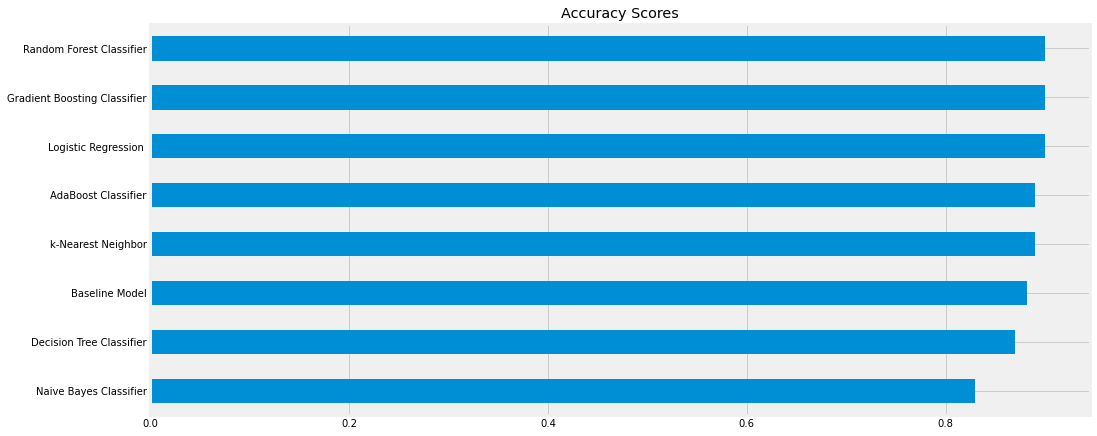

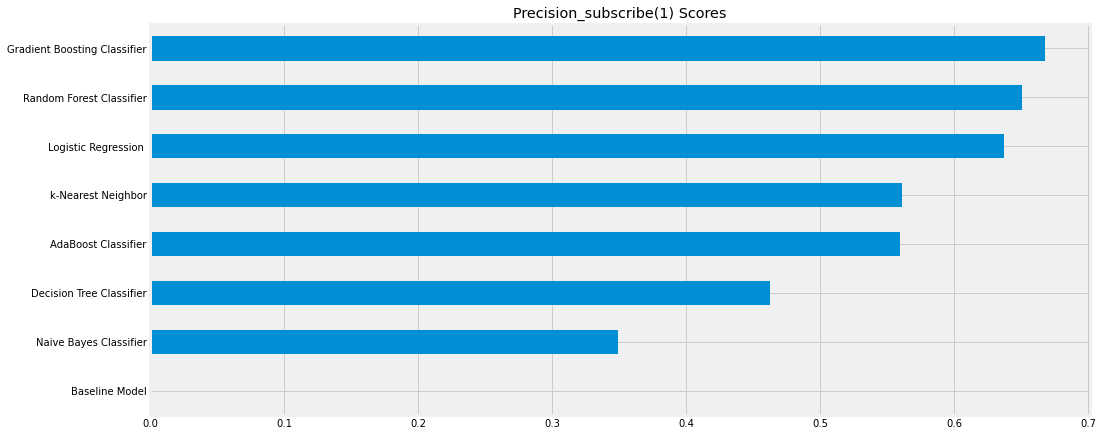

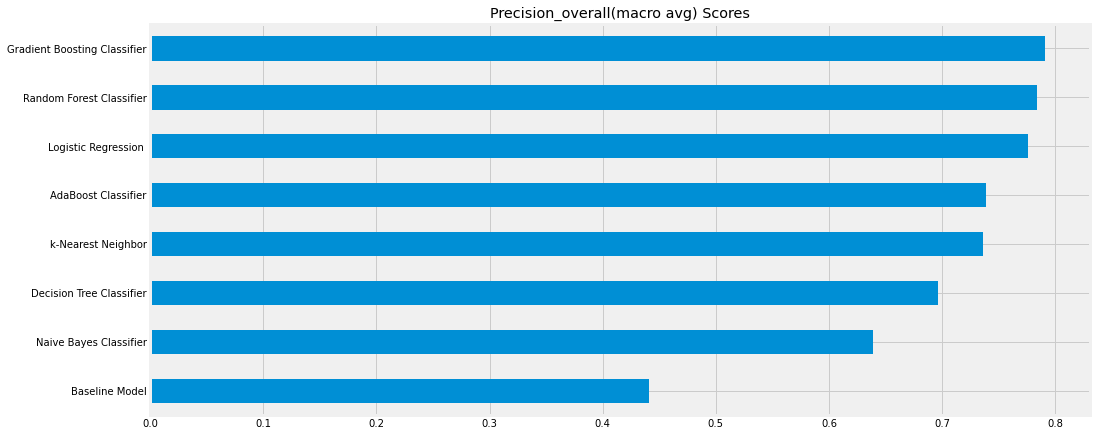

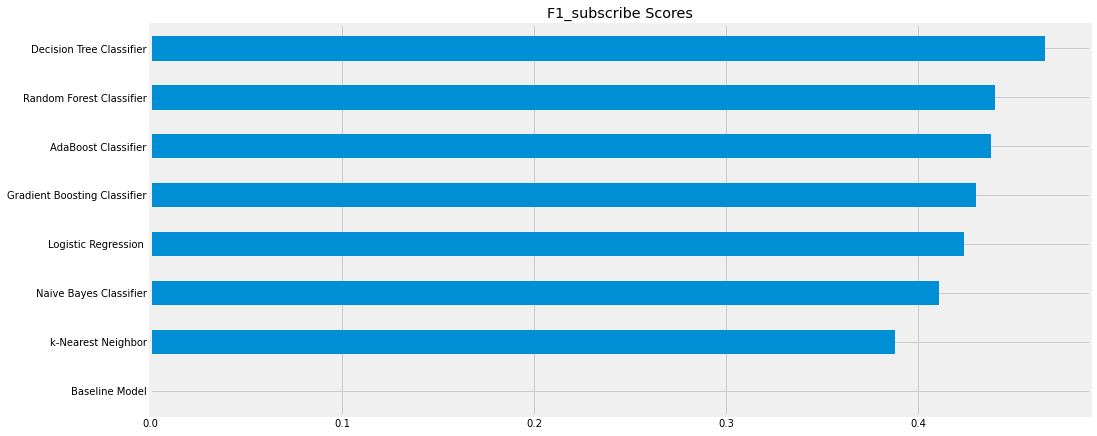

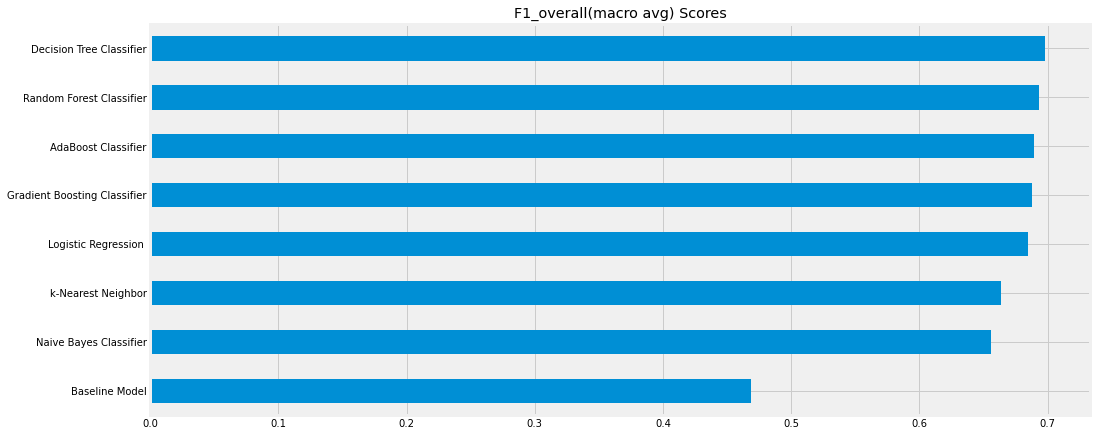

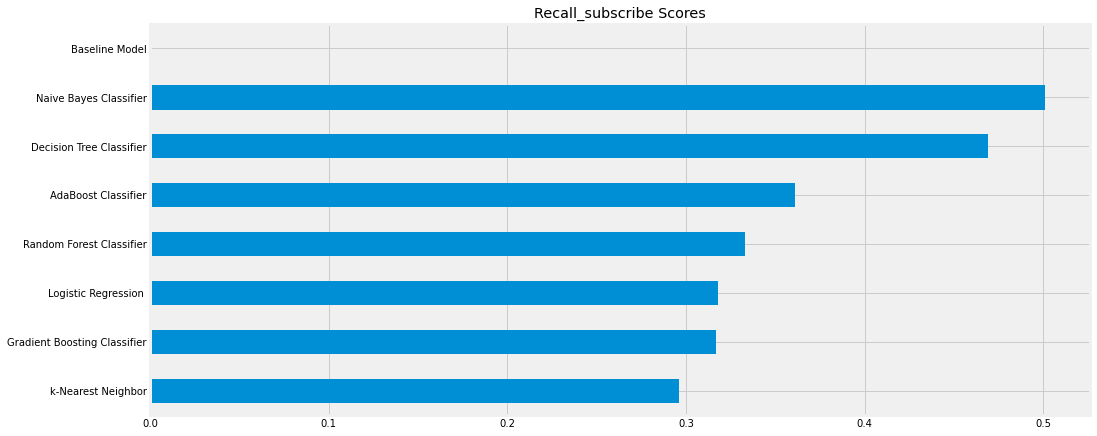

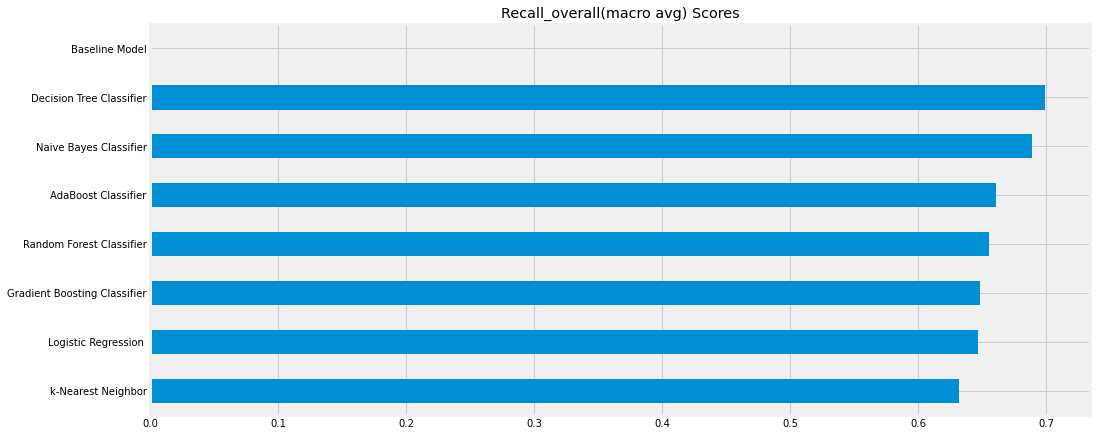

In [80]:
for i, types in enumerate(df.columns):
    temp = df[types]
    plt.figure(i, figsize = (15, 7.2))
    temp.sort_values(ascending = True).plot(kind = 'barh')
    plt.title(f'{types.capitalize()} Scores')
    plt.show()


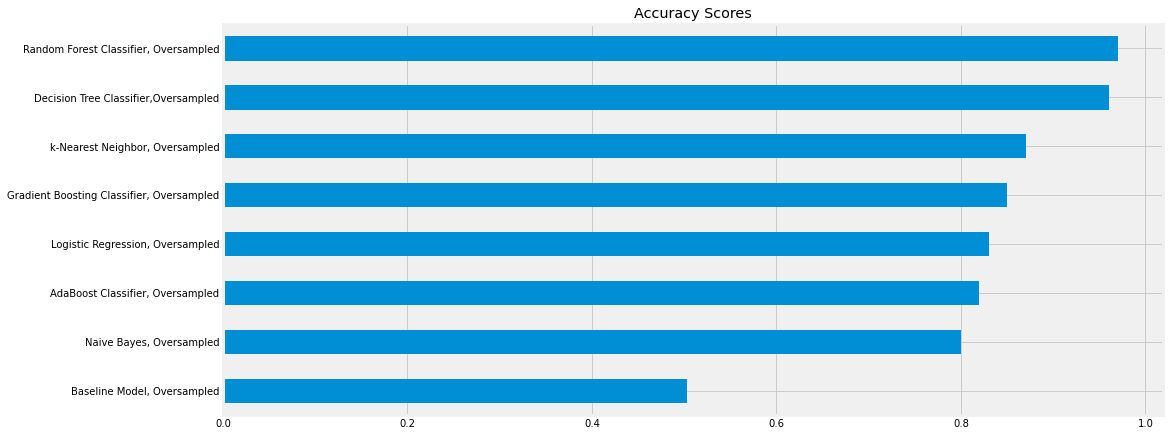

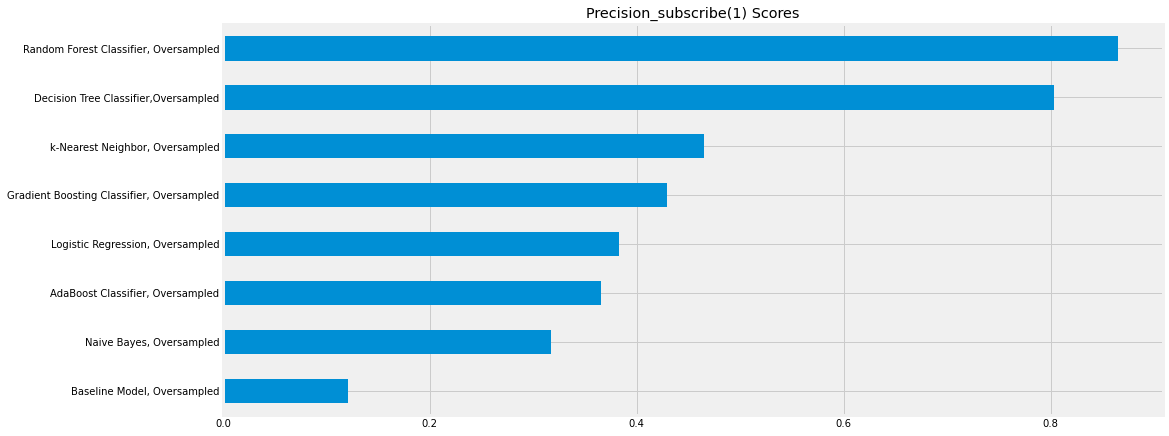

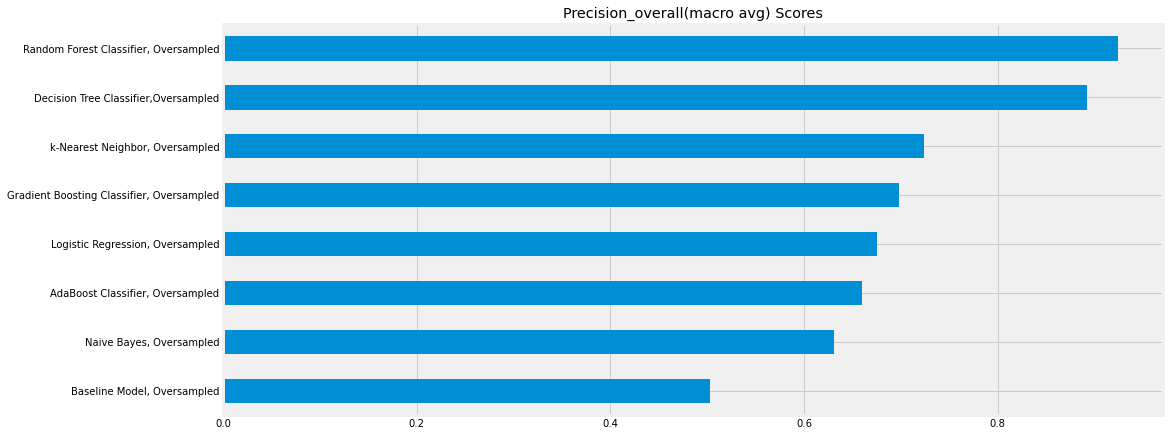

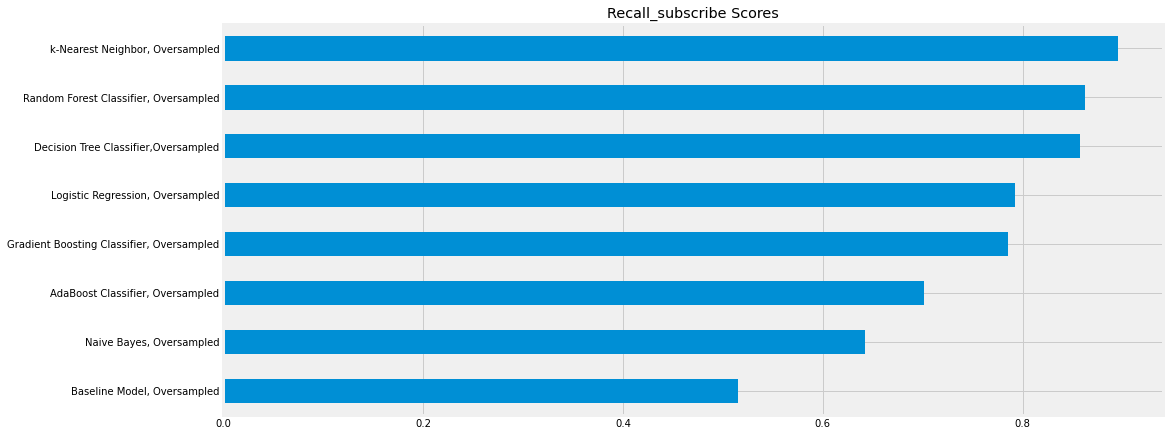

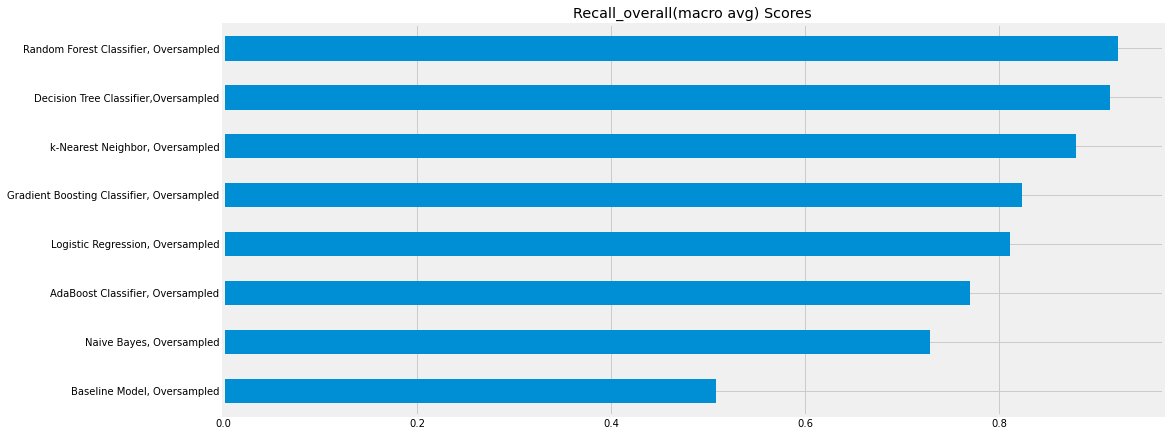

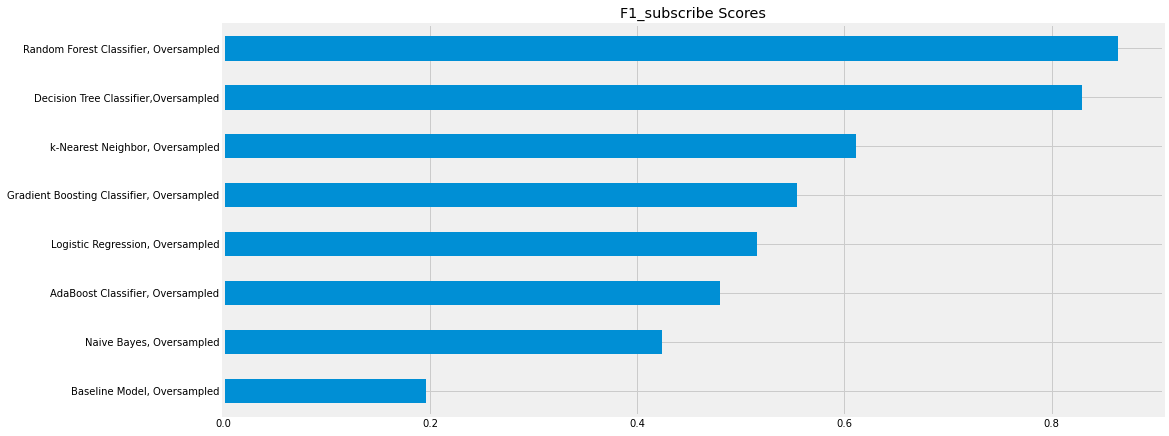

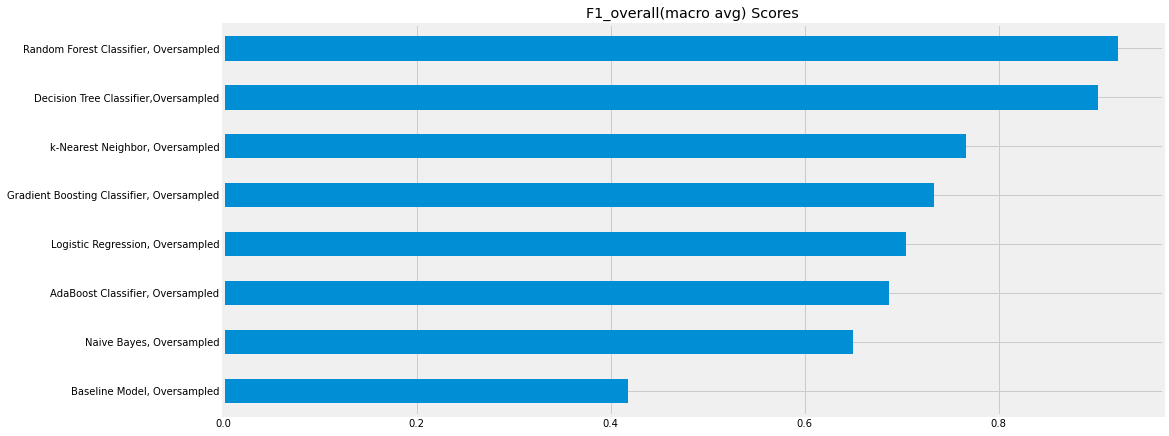

In [81]:
for i, types in enumerate(df_oversampled.columns):
    temp = df_oversampled[types]
    plt.figure(i, figsize = (15, 7.2))
    temp.sort_values(ascending = True).plot(kind = 'barh')
    plt.title(f'{types.capitalize()} Scores')
    plt.show()



# Outcomes:

- First we set the baseline with dummy classifier model.
- Then we had use the Standard machine learning models(Logistic Regression, Naive Bayes, KNN, Decision tree) with hyperparameter tuning and we found the best accuracy of 90% with Logistic Regression model.
- Then we oversampled our data to balence the outcome classes using SMOTE and in this case we found the best accuracy of 96% with Dicision Tree classifier.
- Then we had implimented self ensembled models (Random Forest, AdaBoost Classifier, Gradient Boost Classifier) and we found the best accuracy around 90% with Random Forest and Gradient Boosting classifier. 
- Finally we applied these algorithms on oversampled data and found the best accuracy of 97% with Random Forest Classifier.

## Thanks